<b>The Geography of Climate Migration</b>

*Michał Burzyński* (michal.burzynski@liser.lu), *Frédéric Docquier* (frederic.docquier@liser.lu) & *Hendrik Scheewel* (hendrik.scheewel@uliege.be)

# Load packages

In [2]:
# import packages
import datetime
import io
import itertools
import math
from itertools import cycle
from string import ascii_lowercase as abc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import requests
import seaborn as sns
import statsmodels.formula.api as sm
from IPython.display import HTML
from numba import float64, guvectorize, jit, njit, vectorize
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

sns.set_palette('Paired')
colors = sns.color_palette()
sns.set()
sns.set(style="white")
#rcParams['font.family'] = 'monospace'

from ipywidgets import HTMLMath

In [ ]:
# Create necessary folders
import os
for folder in ['graphs','output','tables','quickstart']:
    if folder not in os.listdir():
        os.mkdir(folder)

In [3]:
R = ('a', 'n')                      # regions
S = ('l', 'h')                      # skills
B = ('d', 'f')                      # areas
T = (2010, 2040, 2070, 2100)  # periods of interest

# Model class

In [4]:
class model:
    def __init__(self,
                 name, # name of the model instance
                 label=None, # label for plots
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 χ={'d': 0.0, 'f': 0.5}, # income loss due to forced discplacement
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 κ = {'a': 0.0, 'n': 0.198009171657804},
                 Γ__η_bar = {'a': 1.32558139534884, 'n': 1.878},
                 ε = {'a': 0.324228560775267, 'n': 0.276894909527694},
                 γ = 1.00256317290118,
                 tol=1e-5, # tolerance parameter
                 inputs='inputs.xlsx', # input of data
                 sea_level = 1.1,
                 temperature = 2.09): # climate change scenario
        
        self.κ = κ
        self.Γ__η_bar = Γ__η_bar
        self.ε = ε
        self.γ = γ
        
        self.σ, self.τ, self.μ, self.χ, self.tol  = σ, τ, μ, χ, tol
        self.sea_level = sea_level
        self.temperature = temperature
        
        
        self.name = name
        self.label = label
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim)))).sort_index()

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']
        data_irsbt.index.name = 'Country'
        # irsbt = origin-destination-region-skill-time-specific
        data_ijrst = get_input(inputs, 'ijrsbt') 
        data_ijrst.columns.names = ['Variable','r','s','b','t','Destination']
        data_ijrst.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.bddm = data_i['bddm'] # BDDM regions
        self.latitude = data_i['latitude'] # Latitude
        self.longitude = data_i['longitude'] # Latitude
        self.Y = data_irt['Y'] # GDP
        self.Γ__w = data_irt['Γ__w'] # high-to-low-skill wage ratio
        self.L = data_irst['L'] # resident population
        self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.Mij = data_ijrst['Mij'] # number of emigrants
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        # Temperature scenario
        self.D = pd.read_excel(inputs,
            sheet_name='temperature',
            index_col=0,
            header=[0,1,2,3])[temperature]['D']
        self.D.columns.names = ['r','t']
        
        # Sea-level rise scenario
        self.ω = pd.read_excel(inputs,
            sheet_name='sea_level_rise',
            index_col=0,
            header=[0,1,2,3])[sea_level]['ω']
        self.ω.columns.names = ['r','t']
        
        # Geodataframe containing shape information
        self.shapes = gpd.read_file('shapes/shapes.shp').set_index('Country')
        
        # Lexsort all dataframes:
        for i in list(self.__dict__):
            if isinstance(self.__dict__[i],pd.DataFrame):
                try:
                    if self.__dict__[i].columns.is_lexsorted() == False:
                        self.__dict__[i].columns.sortlevel(inplace=True)
                except:
                    pass

        # Make a copy of the data before it is overwritten
        for var in ['Y','Γ__w','L','Mij']:
            self.__dict__[var+'_data'] = self.__dict__[var]

In [5]:
def MidxDataFrame(self,dim,value=np.nan):
    """ Creates multi-indexed empty dataframe with country-index"""
    
    MultiIndexDic = {
    'irt': {
        'levels': [R,T],
        'names': ['r','t'],
    },
    'ist': {
        'levels': [S,T],
        'names': ['s','t'],
    },
    'irs': {
        'levels': [R,S],
        'names': ['r','s'],
    },
    'irst': {
        'levels': [R,S,T],
        'names': ['r','s','t'],
    },
    'irsbt': {
        'levels': [R,S,B,T],
        'names': ['r','s','b','t'],
    },
    'ijrs': {
        'levels': [R,S,list(self.countries)],
        'names': ['r','s','Destination'],
    },
    'ijrst': {
        'levels': [R,S,T,list(self.countries)],
        'names': ['r','s','t','Destination']
    },
    'ijrsbt': {
        'levels': [R,S,B,T,list(self.countries)],
        'names': ['r','s','b','t','Destination']
    },
    'ijrsft': {
        'levels': [R,S,['f'],T,list(self.countries)],
        'names': ['r','s','b','t','Destination']}}
    
    
    return(pd.DataFrame(value, index=self.countries,
                        columns=pd.MultiIndex.from_product(
                            MultiIndexDic[dim]['levels'],
                            names=MultiIndexDic[dim]['names']).sortlevel()[0]))

model.MidxDataFrame = MidxDataFrame

## Functions

### Calibration functions

In [6]:
#############################
''' Calibration functions '''
#############################

# The following two functions are the inverse functions of mii and mij
def xii_fun(self,r, s):
    ''' internal migration cost'''
    return(1 - self.mii[(r,s,'d',2010)]**self.μ * (self.v[(r,s,'d',2010)]/self.v[('n',s,'d',2010)]))

model.xii_fun = xii_fun

def xij_fun(self,r, s):
    ''' international migration cost '''
    return(np.array(1 - self.mij[(r,s,'d',2010)]**self.μ * (1/self.V[(r,s,'d',2010)])\
                    * (1 - np.diag(np.ones(len(self.countries))))))

model.xij_fun = xij_fun

### Model functions

In [7]:
#######################
''' Model functions '''
#######################

def Γ__L_fun(self,r, t):
    ''' Skill ratio in the labor force '''
    return(self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

model.Γ__L_fun = Γ__L_fun

def Γ__η_fun(self, r, t):
    ''' Skill bias in relative productivity '''
    return(self.Γ__η_bar[r] * self.Γ__L[(r, t)]**self.κ[r])

model.Γ__η_fun = Γ__η_fun

def η_fun(self, r, s, t):
    ''' Relative productivity '''
    if s == 'h':
        return(self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)]))
    else:
        return(1 / (1 + self.Γ__η[(r, t)]))
    
model.η_fun = η_fun


def A_fun(self, r, t):
    ''' Total factor productivity '''
    return (self.γ**(t - 2010) * self.D[(r, t)] * self.A_bar[r] * self.Γ__L[(r, t)]**self.ε[r])

model.A_fun = A_fun

def Y_fun(self, r, t):
    ''' Gross domestic product '''
    if r == 'n':
        return(self.A[(r, t)]\
               * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((self.σ[r]-1)/self.σ[r])\
                  + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
    else:
        return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)] + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

model.Y_fun = Y_fun

def w_fun(self, r, s, t):
    ''' Wage rate '''
    if r == 'a':
        return (self.η[(r, s, t)] * self.A[(r, t)])
    if r == 'n':
        return (self.η[(r, s, t)] * self.A[(r, t)] ** ((self.σ[r]-1)/self.σ[r]) 
                * (self.Y[(r, t)] / self.L[(r, s, t)])**(1 / self.σ[r]))
    
model.w_fun = w_fun
    
def Γ__w_fun(self, r, t):
    ''' High-low-skilled wage ratio '''
    return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

model.Γ__w_fun = Γ__w_fun

def c_fun(self, r, s, b, t):
    ''' Consumption '''
    return(self.w[(r, s, t)] )

model.c_fun = c_fun


def v_fun(self, r, s, b, t):
    ''' Inner utility '''
    return((1 - self.τ[r]) * self.c[(r, s, b, t)])

model.v_fun = v_fun

def V_fun(self, r, s, b, t):
    ''' Relative utility between two regions '''
    return(np.outer(1/self.v[(r,s,b,t)],self.v[('n',s,'d',t)]))

model.V_fun = V_fun

def mii_fun(self, r, s, b, t):
    ''' Internal emigrant to stayer ratio '''
    return(((self.v[('n', s, 'd', t)]/self.v[(r, s, b, t)])
            * ( (1-self.xii[(r, s)])/(1-self.χ[b])))**(1/self.μ))

model.mii_fun = mii_fun

def mij_fun(self, r, s, b, t):
    ''' International emigrant to stayer ratio'''
    return(np.array(self.V[(r,s,'d',t)]**(1/self.μ)\
                    * ((1-self.xij[(r,s)])/(1-self.χ[b]))**(1/self.μ)\
                    * (1-np.diag(np.ones(len(self.countries))))))    

model.mij_fun = mij_fun

def Ms_fun(self, r, s, b, t):
    """ Stayers """
    if b == 'd':
        share = 1-self.ω[(r,t)]
    else:
        share = self.ω[(r,t)]
    return((share * self.N[(r, s, t)])/
           (1 + self.mii[(r, s, b, t)] + self.mij[(r,s,b,t)].sum(1)))

model.Ms_fun = Ms_fun

def Mii_fun(self, r, s, b, t):
    """ Internal emigrants from dry area """
    return(self.mii[(r, s, b, t)] * self.Ms[(r, s, b, t)])

model.Mii_fun = Mii_fun

def Mij_fun(self, r, s, b, t):
    """ Internal emigrants from dry area """
    return(np.array(self.mij[(r,s,b,t)].multiply(self.Ms[(r,s,b,t)],0)))

model.Mij_fun = Mij_fun

def Iii_fun(self, r,s,t):
    """ Internal immigrant flow"""
    rprime = set(R).difference(r).pop()
    return(self.Mii[(rprime,s,'d',t)] + self.Mii[(rprime,s,'f',t)])

model.Iii_fun = Iii_fun

def Iij_fun(self, r, s, t):
    ''' International immigrant flow '''
    if r == 'a':
        return(0)
    else:
        return((self.Mij[('a',s,'d',t)] + self.Mij[('a',s,'f',t)] \
              + self.Mij[('n',s,'d',t)] + self.Mij[('n',s,'f',t)]).sum(0)) 
    
model.Iij_fun = Iij_fun

def L_fun(self, r,s,t):
    ''' Resident population '''
    rprime = set(R).difference(r).pop()
    L = self.Ms[(r, s, 'd', t)]  +\
        self.Ms[(r, s, 'f', t)]  +\
        self.Iii[(r,s,t)] +\
        self.Iij[(r,s,t)]
    return(np.maximum(self.tol, L))

model.L_fun = L_fun

def N_fun(self, r, s, t):
    ''' Native population '''
    if t < 2040:
        if s == 'l':
            # probabilities to become low-skilled
            p_l = 1 - self.p[(r, 'l', 'd', t-30)]
            p_h = 1 - self.p[(r, 'h', 'd', t-30)]
        else:
            # probabilities to become high-skilled
            p_l = self.p[(r, 'l', 'd', t-30)]
            p_h = self.p[(r, 'h', 'd', t-30)]
        N = self.L[(r, 'l', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l + \
            self.L[(r, 'h', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_h
    else:
        rprime = set(R).difference(r).pop()
        p_l  = self.p[(r,'h','d',t-30)]
        p_h  = self.p[(r,'h','d',t-30)]
        pf_l = self.p[(r,'l','f',t-30)]
        pf_h = self.p[(r,'h','f',t-30)]
        if s == 'l':
            p_l  = 1 - p_l
            pf_l = 1 - pf_l
            p_h  = 1 - p_h
            pf_h = 1 - pf_h
        N = self.Ms[(r, 'l', 'd', t-30)]       * self.n[(r, 'l', 'd', t-30)] * p_l  +\
            self.Ms[(r, 'l', 'f', t-30)]       * self.n[(r, 'l', 'f', t-30)] * pf_l +\
            self.Mii[(rprime, 'l', 'd', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l  +\
            self.Mii[(rprime, 'l', 'f', t-30)] * self.n[(r, 'l', 'f', t-30)] * pf_l +\
            self.Ms[(r, 'h', 'd', t-30)]       * self.n[(r, 'h', 'd', t-30)] * p_l  +\
            self.Ms[(r, 'h', 'f', t-30)]       * self.n[(r, 'h', 'f', t-30)] * pf_l +\
            self.Mii[(rprime, 'h', 'd', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_l  +\
            self.Mii[(rprime, 'h', 'f', t-30)] * self.n[(r, 'h', 'f', t-30)] * pf_l
    return(np.maximum(self.tol, N))

model.N_fun = N_fun

## Calibration

### Calibration of technology

In [8]:
def technology_calib(self):
    self.Γ__L = self.MidxDataFrame('irt')
    self.Γ__η = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.A = self.MidxDataFrame('irt')
    self.A_bar = pd.DataFrame(index=self.countries)

    t = 2010

    for r in R:
        self.Γ__L[(r,t)] = self.L[(r,'h',t)]/self.L[(r,'l',t)]
    for r in R:
        if r == 'n':
            self.Γ__η[(r,t)] = (self.Γ__w[(r,t)] *(self.Γ__L[(r,t)])**(1/self.σ[r]))
        else:
            self.Γ__η[(r,t)] = self.Γ__η_bar[r]
            
    t = 2010
    df = pd.DataFrame({'Γ__η': self.Γ__η[('n',t)],'Γ__L': self.Γ__L[('n',t)]})
    reg = sm.ols(formula="np.log(Γ__η) ~ np.log(Γ__L)", data=df).fit()

    self.κ['n'] = 0.5*reg.params['np.log(Γ__L)']
    self.Γ__η_bar['n'] = np.exp(reg.params['Intercept'])
    
    self.Γ__η_bar = pd.DataFrame(index=self.countries)
    
    for r in R:
        self.Γ__η_bar[r] = self.Γ__η[(r,t)]/((self.Γ__L[(r,t)])**(self.κ[r]))
        
    
    for r in R:
        self.Γ__η[(r,t)] = (self.Γ__η_bar[r] *(self.Γ__L[(r,t)])**(self.κ[r]))
    
    
    for r in R:
        for s in S:
            if s == 'h':
                self.η[(r, s, t)] = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
            else:
                self.η[(r, s, t)] = 1 / (1 + self.Γ__η[(r, t)])
    

    for r in R:
        if r == 'a':
            self.A[(r,t)] = ((self.Y[(r, t)]) /\
                      (self.η[(r,'l',t)] * self.L[(r,'l',t)] +\
                       self.η[(r,'h',t)] * self.L[(r,'h',t)]))
        else:
            self.A[(r,t)] = (self.Y[(r, t)] /\
                     (self.η[(r,'l',t)] * (self.L[(r,'l',t)])**((self.σ[r]-1)/self.σ[r]) +\
                      self.η[(r,'h',t)] * (self.L[(r,'h',t)])**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
            
    for r in R:
        self.A_bar[r] = self.A[(r,t)]/(self.γ**(t - 2010) * (self.Γ__L[(r,t)])**self.ε[r] * self.D[(r,t)])


    def A_fun(r, t):
        ''' Total factor productivity '''
        return (self.A_bar[r] * self.γ**(t - 2010)* self.Γ__L[(r, t)]**self.ε[r] * self.D[(r, t)])
        
    def Y_fun(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)]\
                   * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((self.σ[r]-1)/self.σ[r])\
                      + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)] + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))
    
    
    #### TRY TO PREDICT Y HERE:
    t = 2010
    for r in R:
        self.A[(r,t)] = A_fun(r, t)
    for r in R:
        self.Y[(r,t)] = Y_fun(r, t)    
    
model.technology_calib = technology_calib

In [9]:
def Γ__L_cal(self,r, t):
    ''' Skill ratio in the labor force '''
    return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

### Calibration of migration costs

In [10]:
def calib_migcosts(self):
    """ Calibration of migration costs """
    
    t = 2010
    
    # Create empty dataframes for emigrant to stayer ratios, stayers and migrants
    self.N = self.MidxDataFrame('irst')
    self.miF = self.MidxDataFrame('irst')
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mii = self.MidxDataFrame('irsbt')
    self.MiF = self.MidxDataFrame('irst')

    for s in S:
        v_n_s       = 1 # share of immigrants that go to urban area
        m_an_s      = self.mii[('a',s,'d',2010)] # exog. rural internal emigrant-to-stayer ratio
        m_na_s      = 0 # urban internal emigrant-to-stayer ratio
        
        L_a_s_hat   = self.L[('a',s,2010)] # rural residents
        L_n_s_hat   = self.L[('n',s,2010)] # urban residents
        L_s_hat     = L_a_s_hat + L_n_s_hat # all residents
        
        M_aF_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(1) # rural emigrants
        M_nF_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(1) # urban emigrants
        M_F_s_hat   = M_aF_s_hat + M_nF_s_hat # all emigrants
        
        I_Fa_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(0) # rural immigrants
        I_Fn_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(0) # urban immigrants
        I_s_hat     = I_Fa_s_hat + I_Fn_s_hat # all immigrants
        
        N_s_hat     = L_s_hat + M_F_s_hat - I_s_hat # all natives

        # for all countries: internal emigrant-to-stayer ratios of high-skilled = 0.3
        if s == 'h':
            m_an_s = pd.Series(0.3,index=self.countries)
        # problematic observations: set internal emigrant to stayer ratio = 0
        if s == 'l':
            m_an_s.loc['Tonga'] = 0

        M_aa_s = L_a_s_hat - (1 - v_n_s) * I_s_hat # rural stayers = residents - immigrants
        m_aF_s = M_aF_s_hat/M_aa_s # rural internat. emigrant-to-stayer ratio
        M_nn_s = L_n_s_hat - m_an_s * M_aa_s - v_n_s * I_s_hat # urban stayers
        m_nF_s = M_nF_s_hat/M_nn_s # urban internat. emigrant-to-stayer ratio
        
        N_a_s  = M_aa_s * (1 + m_an_s + m_aF_s) # rural natives
        N_n_s  = M_nn_s * (1 + m_na_s + m_nF_s) # urban natives
        
        M_an_s = m_an_s * M_aa_s # rural internal emigrants
        M_na_s = m_na_s * M_nn_s # urban internal emigrants
        
        M_aF_s = m_aF_s * M_aa_s # rural internat. emigrants
        M_nF_s = m_nF_s * M_nn_s # urban internat. emigrants
        
        RES_a  = abs(N_a_s - (M_aa_s + M_aF_s + M_an_s)) # residual
        RES_n  = abs(N_n_s - (M_nn_s + M_nF_s + M_na_s)) # residual

        # Assign derived values to dataframes
        self.mii[('a',s,'d',t)]  = m_an_s # internal rural emigrant-to-stayer ratio
        self.mii[('n',s,'d',t)]  = m_na_s # internal urban emigrant-to-stayer ratio
        
        self.miF[('a',s,t)]      = m_aF_s # internat. rural emigrant-to-stayer ratio
        self.miF[('n',s,t)]      = m_nF_s # internat. urban emigrant-to-stayer ratio
        
        self.N[('a',s,t)]        = N_a_s  # rural natives
        self.N[('n',s,t)]        = N_n_s  # urban natives
        
        self.Ms[('a',s,'d', t)]  = M_aa_s # rural stayers
        self.Ms[('n',s,'d', t)]  = M_nn_s # urban stayers
        
        self.Mii[('a',s,'d', t)] = M_an_s # rural internal emigrants
        self.Mii[('n',s,'d', t)] = M_na_s # urban internal emigrants
        
        self.MiF[('a',s,t)]      = M_aF_s # rural internat. emigrants
        self.MiF[('n',s,t)]      = M_nF_s # urban internat. emigrants
        
    self.mij = self.MidxDataFrame('ijrsbt') 
    
    for r in R:
        for s in S:
            self.mij[(r,s,'d',t)] = np.array(self.Mij[(r,s,'d',t)].multiply((1/self.Ms[(r,s,'d',t)]),0))

    # Create new empty dataframes for variables to derive
    self.Γ__L = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.Γ__η = self.MidxDataFrame('irt')
    self.Γ__w = self.MidxDataFrame('irt')
    self.Y = self.MidxDataFrame('irt')
    self.w = self.MidxDataFrame('irst')
    self.c = self.MidxDataFrame('irsbt')
    self.v = self.MidxDataFrame('irsbt')
    self.V = self.MidxDataFrame('ijrsbt')
    self.xii = self.MidxDataFrame('irs')
    self.xij = self.MidxDataFrame('ijrs')

    
    b = 'd'
    t = 2010
    for r in R:
        self.Γ__L[(r, t)] = self.Γ__L_fun(r, t)
        self.Γ__η[(r, t)] = self.Γ__η_fun(r, t)
    for r in R:
        for s in S:
            self.η[(r, s, t)] = self.η_fun(r, s, t)
        self.A[(r, t)] = self.A_fun(r, t)
        self.Y[(r, t)] = self.Y_fun(r, t)
    for r in R:
        for s in S:
            self.w[(r, s, t)] = self.w_fun(r, s, t)
    for r in R:
        self.Γ__w[(r, t)] = self.Γ__w_fun(r, t)
    for r in R:
        for s in S:
            self.c[(r, s, b, t)] = self.c_fun(r, s, b, t)
            self.v[(r, s, b, t)] = self.v_fun(r, s, b, t)
    for r in R:
        for s in S:
            self.V.loc[:,(r, s, b, t)] = self.V_fun(r, s, b, t)
    for r in R:
        for s in S:
            self.xii[(r, s)] = self.xii_fun(r,s)
            self.xij.loc[:,(r,s)] = np.array(self.xij_fun(r,s))
                
                
    Mijf = self.MidxDataFrame('ijrsft').fillna(0)
    self.Mij = self.Mij.join(Mijf)
    
    for r in R:
        for s in S:
            self.Mii[(r,s,'f',2010)] = 0
            
    
    ############# NEW ###############
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]

    for r in R:
        for s in S:
                self.mii[(r, s, b, t)] = self.mii_fun(r, s, b, t)
    for r in R:
        for s in S:
                self.mij.loc[:,(r, s, b, t)] = self.mij_fun(r, s, b, t)
    for r in R:
        for s in S:
                self.Ms[(r, s, b, t)]  = self.Ms_fun(r, s, b, t)
                self.Mii[(r, s, b, t)] = self.Mii_fun(r, s, b, t)
                self.Mij.loc[:,(r, s, b, t)] = self.Mij_fun(r, s, b, t)    
    
model.calib_migcosts = calib_migcosts

### Exogenous fertility

In [11]:
def fertility(self):

    for t in [2010,2040,2070,2100]:
        for r in R:
            for s in S:
                for b in B:
                    self.n[(r,s,b,t)] = self.n[(r,s,'d',t)]
                    self.p[(r,s,b,t)] = self.p[(r,s,'d',t)]      

model.fertility = fertility

## Simulation

In [12]:
def simulate(self, max_iter=150, report=False, report_from=0,quickstart=False,mig_config='full'):
    """ Load  parameters """

    # Create empty dataframes
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt')
    self.mOECD = self.MidxDataFrame('irsbt')
    self.MOECD = self.MidxDataFrame('irsbt')
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt')
    self.Iii = self.MidxDataFrame('irst')
    self.Iij = self.MidxDataFrame('irst')
    self.V = self.MidxDataFrame('ijrsbt')
        
                
    """ 2010-2100 Loop """
    def loop2010_2100(quick=quickstart,mig_config=mig_config):
        plt.figure(figsize=(15, 2.5))
        conv = 0.9 # convergence parameter
        
        
        Ts = [2010, 2040, 2070, 2100]
        for t in Ts:
            count = 0 # counter
            self.ΔL = 1
            
            ''' QUICKSTART FUNCTIONALITY '''
            quickstart = quick
            if quickstart == True:
                    try:
                        QUICK_L = pd.read_hdf('quickstart/'+self.name+'.h5',key='L')
                        for r in R:
                            for s in S:
                                self.L[(r, s, t)] = QUICK_L[(r, s, t)] 
                    except:
                        quickstart = False
                    
            if quickstart == False:
                if t != 2010:
                    for r in R:
                        for s in S:
                            self.L[(r, s, t)] = 1
            
            # quickstart indicator
            if (t == 2010) & (quickstart == True):
                display(HTML("<b>Launched with quickstart!</b>"))
                
            
            ''' MIGRATION SCENARIOS '''
            incr = 0.0001
            # migration scenarios
            if t == 2040:
                if mig_config == 'no_south':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(self.OECD,1))
                    self.xij = self.xij.fillna(1)

                if mig_config == 'no_north':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(0**self.OECD,1))
                    self.xij = self.xij.fillna(1)
                if mig_config == 'proporional_increase':
                    for r in R:
                        for s in S:
                            self.xij[(r,s)] = np.minimum(self.xij[(r,s)]*(1+incr),1)
                            self.xii[(r,s)] = np.minimum(self.xii[(r,s)]*(1+incr),1)
                if mig_config == 'proporional_decrease':
                    for r in R:
                        for s in S:
                            self.xij[(r,s)] = np.maximum(self.xij[(r,s)]*(1-incr),0)
                            self.xii[(r,s)] = np.maximum(self.xii[(r,s)]*(1-incr),0)
                if mig_config == 'no_international':
                    self.xij.loc[:,:] = 1
                if mig_config == 'no_internal':
                    self.xii.loc[:,:] = 1
                if mig_config == 'no':
                    self.xij.loc[:,:] = 1
                    self.xii.loc[:,:] = 1
                    
            # quadratic differentials in L
            Δ = self.ΔL**2
            # create vector to track evolution of quadratic differentials
            self.Δ = [] 

            while (Δ > self.tol) & (count < max_iter):
                if count > 0:
                    # after first run, L(r,s,t) = convex combination of prediction & guess
                    self.L[(r, s, t)] = conv * self.L[(r, s, t)] + (1-conv) * self.L_old[(r, s)]
                    

                # track old value of L
                self.L_old = self.L.xs(t, 1, 2)
                
                for r in R:
                    self.Γ__L[(r, t)] = self.Γ__L_fun(r, t)
                    self.Γ__η[(r, t)] = self.Γ__η_fun(r, t)
                for r in R:
                    for s in S:
                        self.η[(r, s, t)] = self.η_fun(r, s, t)
                    self.A[(r, t)] = self.A_fun(r, t)
                    self.Y[(r, t)] = self.Y_fun(r, t)
                for r in R:
                    for s in S:
                        self.w[(r, s, t)] = self.w_fun(r, s, t)
                for r in R:
                    self.Γ__w[(r, t)] = self.Γ__w_fun(r, t)
                    for s in S:
                        for b in B:
                            self.c[(r, s, b, t)] = self.c_fun(r, s, b, t)
                            self.v[(r, s, b, t)] = self.v_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.V.loc[:,(r, s, b, t)] = self.V_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mii[(r, s, b, t)] = self.mii_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mij.loc[:,(r, s, b, t)] = self.mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mOECD[(r,s,b,t)] = self.mij[(r,s,b,t)].multiply(self.OECD,1).sum(1)
                for r in R:
                    for s in S:
                        for b in B:
                            self.Ms[(r, s, b, t)]  = self.Ms_fun(r, s, b, t)
                            self.Mii[(r, s, b, t)] = self.Mii_fun(r, s, b, t)
                            self.Mij[(r, s, b, t)] = self.Mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.MOECD[(r,s,b,t)] = self.Mij[(r,s,b,t)].multiply(self.OECD,1).sum(1)
                for r in R:
                    for s in S:
                        self.Iii[(r,s,t)] = self.Iii_fun(r, s, t)
                        self.Iij[(r,s,t)] = self.Iij_fun(r, s, t)
                    for r in R:
                        for s in S:
                            if t != 2010:
                                self.L[(r, s, t)] = self.L_fun(r, s, t)
                for r in R:
                    for s in S:
                        self.N[(r, s, t+30)] = self.N_fun(r, s, t+30)
                        
                self.ΔL = ((self.L_old - self.L.xs(t, 1, 2))**2).sum().sum()
                Δ = self.ΔL
                self.Δ.append(Δ)
                
                count += 1
               
                
            if report == True:
                plt.subplot(1, len(Ts), int((t-Ts[0])/30+1))
                plt.plot(self.Δ[report_from:max_iter])
                plt.title(r'Year = '+str(t)
                         +'\n'+r'$N$ of Iterations = '+str(count)
                         +'\n'+r'$\Delta L$ = '+str(self.ΔL))
                plt.grid(True)
                plt.xlabel(r'iteration i')
                plt.ylabel(r'$\Delta L_i^2$')
                plt.yscale(r'symlog')
        plt.tight_layout()
        plt.show()
        

    loop2010_2100(quick=quickstart,mig_config=mig_config)
    
    ''' Peoples matrix M containing all stayers, internal and international migrants = world population '''
    Ms  = self.Ms.unstack().reset_index()
    Mii = self.Mii.unstack().reset_index()
    Mij = self.Mij.unstack().reset_index()
    Ms['Destination']  = Ms['Country']
    Mii['Destination'] = Mii['Country']
    Mii['r'] = Mii['r'].replace(['a','n'],['n','a'])
    Ms  = Ms.set_index(['r','s','b','t','Country','Destination'])
    Mii = Mii.set_index(['r','s','b','t','Country','Destination'])
    Mij = Mij.set_index(['r','s','b','t','Country','Destination'])
    self.M = pd.concat([Ms,Mii,Mij],axis=0,keys=['Stayers','Internal','International'],names=['Type'])
    self.M = self.M.reset_index()
    self.M.Type = np.where((self.M.Type == 'Stayers') & (self.M.b == 'f'),'Local',self.M.Type)
    self.M = self.M.set_index(['r','s','b','t','Country','Destination','Type'])
    
    OECD = list(self.OECD[self.OECD == 1].index)
    
    def isOECDfun(x):
        if x in OECD:
            return('N')
        else:
            return('S')

    isOECD = np.vectorize(isOECDfun)

    self.M['F-T'] = list(pd.Series(isOECD(self.M.index.get_level_values('Country'))) +'-'+ pd.Series(isOECD(self.M.index.get_level_values('Destination'))))
    self.M = self.M.set_index('F-T',append=True)
    
    
    
    # Save results for L for eventual quickstart
    self.L.to_hdf('quickstart/'+self.name+'.h5',key='L')
    
    ΔYdataYmodel = abs(self.Y_data.xs(2010,1,1)-self.Y.xs(2010,1,1))
    ΔLdataLmodel = abs(self.L_data.xs(2010,1,2)-self.L.xs(2010,1,2))
    msg = ''
    if (ΔLdataLmodel.sum().sum() < 1) | (ΔLdataLmodel.std().std() < 1):
        msg = msg + "<font color='green'>\U0001f15b</font> "
    else:
        mgs = msg + "<font color='red'>\U0001f15b</font> " +\
        ' $|L^{data}_{2010} - L_{2010}| = %s $' % str(ΔLdataLmodel.sum().sum())
    
    if (ΔYdataYmodel.sum().sum() < 1) | (ΔYdataYmodel.std().std() < 1):
        msg = msg + "<font color='green'>\U0001f168</font> "
    else:
        msg = msg + "<font color='red'>\U0001f168</font> "+\
                    ' $|Y^{data}_{2010} - Y_{2010}| = %s $' % str(ΔYdataYmodel.sum().sum())
    display(HTML(msg))
    
model.simulate = simulate

## Checks & Output

### Checks

#### Native population

In [13]:
def native_split(self,r,s,t,save=False):

    path = 'graphs/population_splits/'
    fig = plt.figure(figsize=(16,26))

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'stayers_f' : (self.Ms[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_d': (self.Mii[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_f': (self.Mii[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internat_emigrants_d': (self.Mij[(r,s,'d',t)].sum(1)/self.N[(r,s,t)]),
                          'internat_emigrants_f': (self.Mij[(r,s,'f',t)].sum(1)/self.N[(r,s,t)]),
                          })

    
    split = split.sort_values(by=list(split))

    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=3)
    plt.title('Native population split in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'N'+str(t)+r+s+'.pdf',dpi=300)
    
model.native_split = native_split

#### Resident population

In [14]:
def resident_split(self,r,s,t,save=False):
    path = 'graphs/population_splits/'
    fig = plt.figure(figsize=(16,26))
    rprime = set(R).difference(r).pop()

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)])/self.L[(r,s,t)],
                          'stayers_f' : (self.Ms[(r,s,'f',t)])/self.L[(r,s,t)],
                          'internal_immigrants_d': (self.Mii[(rprime,s,'d',t)])/self.L[(r,s,t)],
                          'internal_immigrants_f': (self.Mii[(rprime,s,'f',t)]/self.L[(r,s,t)]),
                          'internat_immigrants_a_d': (self.Mij[('a',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_a_f': (self.Mij[('a',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_d': (self.Mij[('n',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_f': (self.Mij[('n',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          })


    if r == 'a':
        split['internat_immigrants_a_d'] = 0
        split['internat_immigrants_n_d'] = 0
        split['internat_immigrants_a_f'] = 0
        split['internat_immigrants_n_f'] = 0
        
    split = split.sort_values(by=list(split))
    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=4)
    plt.title('Resident population composition in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'L'+str(t)+r+s+'.pdf',dpi=300)

model.resident_split = resident_split

#### Further checks

In [15]:
def checks(self):
    YminusLw = []
    NminusL = []
    for t in T:
        # Total production = total income
        YminusLw.append((self.w.xs(t,1,2)*self.L.xs(t,1,2)).sum().sum() - self.Y.xs(t,1,1).sum().sum())
        # Total native population = total resident population
        NminusL.append((self.N.xs(t,1,2)-self.L.xs(t,1,2)).sum().sum())
        
    print('YminusLw',YminusLw)
    print('NminusL',NminusL)
    
model.checks = checks

In [16]:
def urbanization(self):
    self.u = self.MidxDataFrame('ist')

    for t in T:
        for s in S:
            self.u[(s,t)] = self.L[('n',s,t)]/(self.L[('a',s,t)]+self.L[('n',s,t)])
            
model.urbanization = urbanization

#### Comparison with previous paper

In [17]:
class check:
    def __init__(self,
                 name = "BDDM intermediate, only to OECD",
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='BDDM/BDDM_intermediate.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        self.σ = σ 
        self.τ, self.μ = τ, μ
        self.tol = tol
        self.name = name
        self.temperature = 2.09 
        self.sea_level = 1.1
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim))))

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']        
        data_irsbt.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.A = data_irt['A'] # total factor productivity
        self.Y = data_irt['Y'] # GDP
        self.ω = data_irt['ω'] # fraction of flooded population
        self.Γ__w = data_irt['Γ__w']
        self.η = data_irt['η']
        self.L = data_irst['L'] # resident population
        self.N = data_irst['N'] # native population
        self.w = data_irst['w'] # native population
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        self.mOECD = data_irsbt['mOECD']
        self.MOECD = data_irsbt['MOECD']
        self.mii = data_irsbt['mii']
        self.Mii = data_irsbt['Mii']
        self.v = data_irsbt['v']
        
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        
check.MidxDataFrame = MidxDataFrame   
check.urbanization = urbanization

In [18]:
m0 = check()
m0.urbanization()

#### Compare models

In [19]:
def compare_models(model1, model2, 
                   var ='all', annotate_largest=10 ,
                   size=18,fit_reg = False, 
                   cols=4,start_year = 2010,savename=None,scale=('log','log')):
    
    def plot_scatter(model1,model2,i):
        elem = model1.__dict__[i]
        if isinstance(elem, pd.DataFrame):
            display(HTML("<b><center><font size='4'>%s</font></center></b>" %(i)))
            tuples = set(list(model1.__dict__[i])).intersection(set(list(model2.__dict__[i])))
            tuples = sorted(list(tuples), key=lambda item: item[len(list(tuples)[0])-1])

            fig = plt.figure(figsize=(size, math.ceil(len(tuples)/cols)*size/cols))     
            plt.tight_layout()
            plt.subplots_adjust(top=1)
            count = 1
            for tup in tuples:
                if tup[len(tup)-1] >= start_year:
                    y = model1.__dict__[i][tup]
                    x = model2.__dict__[i][tup]
                    fig.add_subplot(math.ceil(len(tuples)/cols), cols, count,aspect='equal')
                    count += 1
                    sns.regplot(x, y, 
                                fit_reg = fit_reg,
                                scatter = True,
                                scatter_kws={'s': 25, 'alpha': 0.7}
                                )
                    for c in model1.countries:
                        largest_diff = ((x/y-1)**2 + (y/x-1)**2).nlargest(annotate_largest)
                        if c in list(largest_diff.index):
                            plt.annotate(model1.iso.loc[c], (x.loc[c], y.loc[c]))
                    lims = [min(x.append(y)), max(x.append(y))]
                    z = np.linspace(lims[0],lims[1])
                    plt.plot(z,z,color='k')
                    plt.xlim(lims)
                    plt.ylim(lims)
                    plt.xlabel(model2.name)
                    plt.ylabel(model1.name)
                    plt.xscale(scale[0])
                    plt.yscale(scale[1])
                    plt.title(i+' ['+str(tup)+']'+'\n'+'Correlation = '+str(round(x.corr(y),6)))
                    #plt.tight_layout()
            plt.show()
            if savename != None:
                fig.savefig(savename)
            
            
    
    if var == 'all':
        for i in sorted(list(model1.__dict__)):
            try:
                plot_scatter(model1,model2,i)
            except:
                pass
                         
    else:
        plot_scatter(model1,model2,var)

## Save output

In [20]:
def save_output(self):
    """ Saves output of simulation """

    self.var = {
    'irt':   ['A', 'D', 'Y', 'xii', 'Γ__L', 'Γ__w', 'Γ__η', 'ω'],
    'irst':  ['Iii', 'Iij', 'L', 'N', 'w', 'xij', 'η'],
    'irsbt': ['Mii', 'Ms', 'c', 'mii', 'n', 'p', 'v'],
    'ijrsbt': ['Mij','mij'],
    }

    def output(dim):
        var_data = [self.__dict__[v].dropna(axis=1, how='all') for v in self.var[dim]]
        return(pd.concat(var_data, keys=self.var[dim], axis=1))

    writer = pd.ExcelWriter(
        'output/'+self.name+'_'+str(datetime.datetime.now())[:10]+'.xlsx', engine='xlsxwriter')

    for dim in self.var.keys():
        output(dim).to_excel(writer, sheet_name=dim)
        output(dim).describe().T.to_excel(
            writer, sheet_name=dim+'_statistics')
    writer.save()
    
model.save_output = save_output

## Output functions

### Immigration rate by country

In [21]:
def out_immigration_rate_by_country(self):
    """ Immigration as percentage of resident population """
    m = self
    L = m.L.unstack().reset_index()
    I = m.Iij.unstack().reset_index()
    L = L.rename(columns={0:'value'})
    I = I.rename(columns={0:'value'})
    L = L.groupby(['t','Country']).sum()
    I = I.groupby(['t','Country']).sum()
    tab1 = (I/L).value.unstack('t')
    sample = ['Germany','France','United Kingdom','Italy','Spain','United States','Canada','Australia']
    custom_dict = {}
    for i in enumerate(sample):
        custom_dict[i[1]] = i[0] 
    tab1 = tab1[tab1.index.isin(sample)]
    tab1 = tab1.iloc[tab1.index.map(custom_dict).argsort()]
    tab1 = round(tab1*100,2)
    return(tab1)

model.out_immigration_rate_by_country = out_immigration_rate_by_country

### Emigration rate by wbregion

In [22]:
def out_emigration_rate_by_wbregion(self):
    """ Emigration as percentage of native population """
    m = self
    N = m.N.unstack().reset_index()
    N = N.rename(columns={0:'value'})
    N = N.groupby(['t','Country']).sum()
    M = m.Mij.dropna(1).unstack().reset_index()
    M = M.rename(columns={0:'value'})
    M = M.groupby(['t','Country']).sum()

    N = N.value.unstack('t').drop(2130,1)
    M = M.value.unstack('t')
    N = N.join(m.wbregion).reset_index().groupby('wbregion').sum()
    M = M.join(m.wbregion).reset_index().groupby('wbregion').sum()
    tab2 = round((M/N)*100,2)
    return(tab2)
    

model.out_emigration_rate_by_wbregion = out_emigration_rate_by_wbregion

### Migrant world stock

In [23]:
def out_migrant_world_stock(self):
    """ World stock of climate migrants by type in 1e06 """
    m = self
    # Local migrants
    Ms = m.Ms.xs('f',1,2).unstack().reset_index().groupby('t').sum().T
    Ms.index = ['Local']

    # Interregional migrants
    Mii = m.Mii.unstack().reset_index().groupby('t').sum().T
    Mii.index = ['Interregional']

    # International migrants
    Mij = m.Mij.unstack().reset_index()
    Mij.Country = np.where(m.OECD.loc[Mij.Country] == 0,'South','North')
    Mij.Destination = np.where(m.OECD.loc[Mij.Destination] == 0,'South','North')
    Mij['i-j'] = Mij.Country + '-' + Mij.Destination
    Mij = Mij.groupby(['i-j','t']).sum()[0].unstack()

    MigWorldAggregates = Ms.append(Mii).append(Mij)/1e06
    return(MigWorldAggregates)
    
model.out_migrant_world_stock = out_migrant_world_stock

### World aggregates

In [24]:
def out_world_aggregates(self,on='World',GDP_scale=10e9, TotalPop_scale=10e6):
    """ 
    Table of world aggregates at custom aggregation levels 
    Available aggregation levels: e.g.
    - 'World' (default)
    - 'Country'
    - 'income_group'
    - 'georegion'
    - 'wb_region'
    """
    m = self
    
    def aggregate(in_var,on):
        if on == 'World':
            var = in_var.unstack().reset_index()
            var = var.groupby(['t']).sum().T
        else:
            var = in_var.unstack().reset_index()
            if on != 'Country':
                var[on] = var['Country'].replace(
                    list(m.__dict__[on].index),
                    list(m.__dict__[on]))
            var = var.groupby(['t',on]).sum().T.stack()
        return(var)

    TotalPop = aggregate(m.L,on)
    UrbanPop = aggregate(m.L.xs('n',1,0),on)
    HSPop = aggregate(m.L.xs('h',1,1),on)
    GDP = aggregate(m.Y,on)


    UrbanShare = round(UrbanPop/TotalPop * 100,2)
    HSShare = round(HSPop/TotalPop * 100,2)
    GDPpCap = GDP/TotalPop
    GDP = GDP/GDP_scale
    TotalPop = TotalPop/TotalPop_scale

    tab = round((TotalPop).rename(index={0:'Population in 10e6'}),2)
    tab = tab.append(UrbanShare.rename(index={0:'Urban Share in \%'}))
    tab = tab.append(HSShare.rename(index={0:'HS Share in \%'}))
    tab = tab.append(round(GDPpCap,2).rename(index={0:'GDP per Worker'}))
    tab = tab.append(round(GDP,2).rename(index={0:'GDP in 10e9 \$US'}))

    return(tab)

model.out_world_aggregates = out_world_aggregates

### Composition of migration

In [25]:
def out_composition_of_mig(self,drop=None):
    """ Stackplot of migrant stock composition """
    m = self
    stocks = m.out_migrant_world_stock()
    if drop != None:
        stocks = stocks.drop(drop,0)

    dt = (stocks/stocks.sum())


    labels = list(dt.index)
    ylist = [dt.loc[i] for i in labels]
    plt.figure(figsize=(10,10))
    plt.stackplot(list(dt),ylist,labels=labels)
    plt.legend()
    plt.xticks(list(dt))
    plt.show()
    
model.out_composition_of_mig = out_composition_of_mig

### Distribution plot

In [26]:
def out_distplot(self,li=[],var='w',save=False,text=False,save_name='income.pdf',cols=1,title=None,ymax=0.75,show_scenario=True):
    from matplotlib import rcParams
    from matplotlib import rc
    rcParams['font.family'] = 'serif'
    rc('text', usetex=True)

    li = [self] + li
    lines = ["-","--",":","-.",(0, (3, 1, 1, 1, 1, 1))]
    linecycler = cycle(lines)
    lw = 2
    c = cycle(['#'+i*6 for i in ['0','5','9','A','B','C']])
    cycle_abc = cycle(abc)
    extr_pov = 0.02

    fig = plt.figure(figsize=(9,5))
    plt.axvline(x=np.log10(extr_pov),ymin=0,c='gray',linewidth=1,linestyle='--')
    plt.annotate('2\%',(np.log10(extr_pov),0.7),horizontalalignment='center',bbox=dict(boxstyle="round", fc="w"))
    txt = r'\noindent Extensive / intensive margin: \\'
    for m in li:
        # Produce data for distributions
        inc = pd.DataFrame(data=[m.L.xs(2100,1,2).unstack(),m.__dict__[var].xs(2100,1,2).unstack()],index=['L',var]).T
        inc = inc.sort_values(by=var)
        inc['PopShareWorld'] = inc['L']/(inc['L'].sum())
        avg = ((inc['L']*inc[var]).sum()/(inc['L'].sum()))
        inc['relInc'] = np.log10(inc[var]/avg)
        
        # Extensive and intensive margins:
        letter = next(cycle_abc)
        those_below = inc['relInc'] <= np.log10(extr_pov)
        ext_marg = (inc['PopShareWorld'][those_below]).sum()
        int_marg = (inc['PopShareWorld'][those_below]*(10**(inc['relInc'][those_below]))).sum()/(inc['PopShareWorld'][those_below]).sum()
        ext_marg = round(100*ext_marg,2)
        int_marg = round(100*int_marg,2)
        txt = txt + r'' + letter + ') ' + str(ext_marg) + r'  \%'+' / ' + str(int_marg) + r' \%'+r' \\'
        
        # Produce density functions
        density = gaussian_kde(list(inc.relInc),weights=list(inc.PopShareWorld))
        xs = np.linspace(-3,2,200)
        density._compute_covariance()
        
        # Plot them
        if m.label != None:
            lbl = m.label
        else:
            lbl = m.name
        label = letter+') '+lbl.replace('_',' ').split(',')[0]
        if show_scenario == True:
            label = label + " [+"+str(m.temperature)+" °C, +"+str(m.sea_level)+" m]"
        plt.plot(xs,density(xs),label=label,linestyle=next(linecycler),c=next(c),linewidth=lw)
 
    # Configurations of plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=cols,handlelength=4)    
    plt.xticks(np.arange(-3,3,1),10.00**np.arange(-3,3,1))
    plt.grid(True,linestyle=':')
    if title != None:
        plt.title("Income as Ratio of World's Average")
    plt.ylabel('Density')
    plt.ylim(0,ymax)
    plt.tight_layout()
    lims = (plt.gca().get_ylim())
    if text == True:
        plt.text(.7,lims[1]*0.7, s=txt,horizontalalignment='left',
        verticalalignment='center',fontsize=11)
    if save == True:
        fig.savefig('graphs/distributions/' + save_name)
    plt.show()
    

model.out_distplot = out_distplot

### Stackplot

In [27]:
def out_stackplot(self,model2=None,drop=None,save=False,name='default.pdf',title=None,ylim=None):
    from matplotlib import rcParams
    from matplotlib import rc
    rcParams['font.family'] = 'serif'
    rc('text', usetex=True)

    
    matrix = (self.out_migrant_world_stock())
    if model2 != None:
        matrix = matrix-model2.out_migrant_world_stock()
    matrix['Type'] = matrix.index
    matrix['Type'] = matrix.Type.str.split('-').apply(lambda x: x[-1])
    matrix = matrix.groupby('Type').sum()
    matrix = matrix.loc[['Local','Interregional','South','North']]
    if drop != None:
        mtx = matrix.drop(drop,0).T
    else:
        mtx = matrix.T
    cols = list(mtx)
    colordict = {
                 'Local': 'lightgray', 
                 'Interregional': 'darkgray', 
                 'North':'yellow', 
                 'South':'black'
                }
    x = list(mtx.index)
    y = []
    hatches = []
    fig = plt.figure(figsize=[8,5])
    colors = []
    for col in cols:
        y = y + [list(mtx[col])]
        colors = colors + [colordict[col]]
    stacks = plt.stackplot(x,np.array(y),labels=cols,colors=colors,lw=1,edgecolor='None')
    plt.xticks(x)
    plt.ylabel('in Mio.')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=4)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.ylim([0,ylim])
    plt.show()
    #display(mtx)
    if save != False:
        fig.savefig('graphs/stackplots/'+name)

model.out_stackplot = out_stackplot

### Lorenz curve

In [28]:
def out_lorenz_curve(self,models=[],plot_2010 = False,cols=1,savename='lorenz.pdf'):
    
    def Lorenz(m,t):
        L = (m.L.xs(t,1,2)).melt()
        Lw = (m.L.xs(t,1,2)*m.w.xs(t,1,2)).melt()
        Lorenz = pd.concat([L.value,Lw.value],keys=['L','Lw'],axis=1).sort_values('Lw')
        Lorenz.L = (100*Lorenz.L/Lorenz.L.sum())
        Lorenz.Lw = (100*Lorenz.Lw/Lorenz.Lw.sum())
        return(Lorenz)

    lines = [":","-","--","-.","-"]
    linestyles = cycle(lines)
    colors = cycle(['#'+i*6 for i in ['0','5','9','A','B','C']])
    fig = plt.figure(figsize=(7,7))
    plt.plot(np.linspace(0,100,100),color='k',linestyle='-',linewidth=0.5)
    if plot_2010 == True:
        plt.plot(Lorenz(m1,2010).L.cumsum(),Lorenz(m1,2010).Lw.cumsum(),label=str(2010),linewidth=1,color='k')
    t = 2100
    li = [self] + models
    for m in li:
        #FALSE:gini = round((100-sum(Lorenz(m,t).L*Lorenz(m,t).Lw))/100,4)
        plt.plot(Lorenz(m,t).L.cumsum(),Lorenz(m,t).Lw.cumsum(),label=m.name+' '+str(t),linewidth=2,color=next(colors),alpha=0.7,linestyle=next(linestyles))

 
    plt.xlabel('Share of Population [\%]')
    plt.ylabel('Share of Income [\%]')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=cols,handlelength=4)  
    plt.tight_layout()
    plt.show()
    fig.savefig('graphs/lorenz/'+savename)
    
model.out_lorenz_curve = out_lorenz_curve

### Sankey plot

In [29]:
def out_sankeyplot(self,region='a', skill='l', area='d', year=2100, 
               aggr_source_by='georegion',aggr_target_by='georegion',
               source_name=None, target_name=None,
               width=800,height=800,save=False):
    """ Sankey plot of migration flows"""
    from ipysankeywidget import SankeyWidget
    from ipywidgets import Layout
    m = self
    layout = Layout(width=str(width), height=str(height))
    t = year
    matrix = m.Mij[region][skill][area][year].unstack().reset_index()
    matrix.columns = ['source','target','value']
    matrix = matrix[matrix.value > 0]
    if aggr_source_by != None:
        matrix.source = matrix.source.apply(lambda x: m.__dict__[aggr_source_by].loc[x])
    if aggr_target_by != None:
        matrix.target = matrix.target.apply(lambda x: m.__dict__[aggr_target_by].loc[x])
    matrix = matrix.groupby(['source','target']).sum()
    matrix = matrix.reset_index()
    palette = itertools.cycle(sns.color_palette())

    if source_name != None:
        matrix = matrix[matrix.source == source_name]
    if target_name != None:
        matrix = matrix[matrix.target == target_name]
    matrix.target = matrix.target + ' '

    dic = dict()

    for i in matrix.source.unique():
        triplet = next(palette)
        dic[i] = '#%02x%02x%02x' % tuple([int(255*x) for x in triplet])

    matrix['color'] = matrix.source.apply(lambda x: dic[x])

    links=matrix.to_dict(orient='records')
    
    wid=SankeyWidget(links = links, layout = layout)

    display(HTML("<h1>%s, region='%s', skill ='%s', area = '%s'</h1>" % (year,region,skill,area)))
    display(wid)
    
    if save == True:
        wid.auto_save_png('graphs/sankey/%s_%s_%s_%s_%s.png' % (m.name,year,region,skill,area))

model.out_sankeyplot = out_sankeyplot

### Tileplot

In [30]:
def out_tileplot(self,gridsize=(30,30),figsize=(25,25),boxscale=2.5, asp_ratio = None):
    m = self
    from matplotlib import patches
    if asp_ratio == None:
        asp_ratio = figsize[1]/figsize[0]
    width  = 0.01*boxscale*(max(m.longitude) - min(m.longitude))
    height = 0.01*boxscale*(max(m.latitude) - min(m.latitude))*asp_ratio
    x = np.linspace(min(m.longitude),max(m.longitude),gridsize[0])
    y = np.linspace(min(m.latitude),max(m.latitude),gridsize[1])
    df = pd.DataFrame([m.longitude,m.latitude,m.iso,m.shapes.geometry.area]).T
    df = df.sort_values(['longitude','latitude'])
    xy = np.array(list(itertools.product(x, y)))
    minima = []
    
    for i in df.index:
        lonlat = (df.longitude.loc[i],df.latitude.loc[i])
        minima.append(min(((lonlat-xy)**2).sum(1)))

    df['minima'] = minima
    
    df = df.sort_values(['minima'])
    
    for i in df.index:
        lonlat = (df.longitude.loc[i],df.latitude.loc[i])
        arg = np.where(((lonlat-xy)**2).sum(1) == min(((lonlat-xy)**2).sum(1)))
        df['longitude'].loc[i] = xy[arg][0][0]
        df['latitude'].loc[i]  = xy[arg][0][1]
        xy = np.delete(xy, arg, 0)
        
    df = df.sort_index()


    N = m.N.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([1,0])[0][2100]
    ω = m.ω.xs(2100,1,1)
    flooded = (N * ω).sum(1)/N.sum(1)
    df['ω'] = flooded

    #df = df.set_index('iso3')
    fig,ax = plt.subplots(1,figsize=figsize)
    plt.scatter(df.longitude,df.latitude,marker='o',s=0,color='lightgray')
    hfont = {'fontname':'Helvetica'}
    for i in df.index:
        ax.add_patch(patches.Rectangle((df.loc[i].longitude-width/2,df.loc[i].latitude-height/2),width,height,linewidth=0,edgecolor=None,facecolor='lightgray'))
        ax.add_patch(patches.Rectangle((df.loc[i].longitude-width/2,df.loc[i].latitude-height/2),width,height*df['ω'].loc[i],facecolor='blue'))
        plt.annotate(df.iso3.loc[i],(df.loc[i].longitude,df.loc[i].latitude),ha='center',va='center',color='black',fontsize=10,**hfont)
        #plt.annotate(m.iso.loc[i],(m.longitude.loc[i],m.latitude.loc[i]),ha='center',va='center',color='black',fontsize=10,**hfont)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Share of people in flooded areas \n Sea-level rise: + 1.1 meters by 2100')
    plt.tight_layout()
    plt.show()
    fig.savefig('graphs/tile_%sx%s.pdf' %(str(gridsize),str(gridsize)))
    return(df)

model.out_tileplot = out_tileplot

### Write Latex table

In [31]:
def write(table, name):
    with open('tables/{name}.tex'.format(name=name),'w') as tf:
        tf.write(table)
        tf.close()

# Run models

## Moderate bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


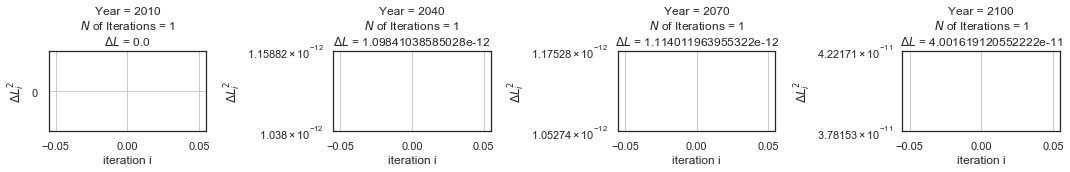

CPU times: user 24 s, sys: 1.09 s, total: 25.1 s
Wall time: 24 s


In [32]:
%%time
m1 = model(name="moderate, bilateral mig",label='Moderate')
m1.technology_calib()
m1.calib_migcosts()
m1.fertility()
m1.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Minor bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


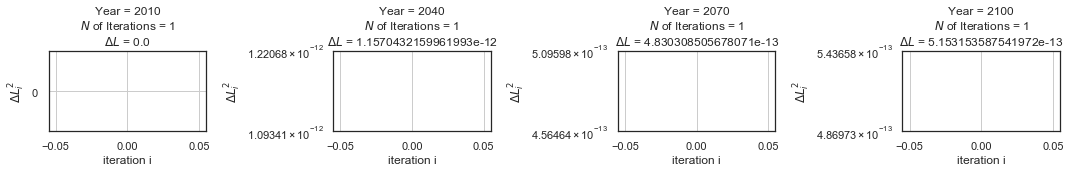

CPU times: user 23.5 s, sys: 366 ms, total: 23.8 s
Wall time: 23.5 s


In [33]:
%%time
m2 = model(name="minor, bilateral mig", label='Minor', sea_level=0, temperature=0.09,)
m2.technology_calib()
m2.calib_migcosts()
m2.fertility()
m2.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Major bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


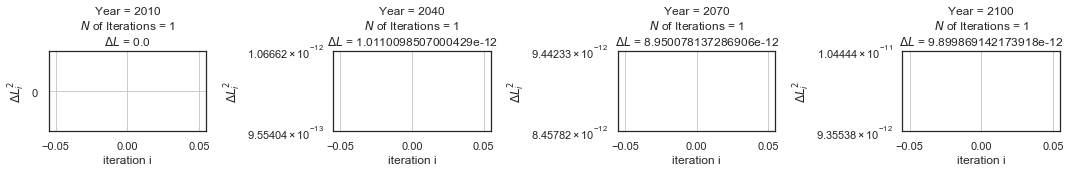

CPU times: user 23.6 s, sys: 441 ms, total: 24.1 s
Wall time: 23.8 s


In [34]:
%%time
m3 = model(name='major, bilateral mig', label='Major', sea_level=1.3, temperature=4.09)
m3.technology_calib()
m3.calib_migcosts()
m3.fertility()
m3.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Moderate no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


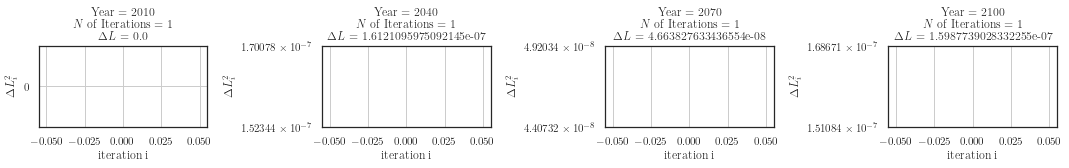

CPU times: user 24.6 s, sys: 1.16 s, total: 25.7 s
Wall time: 30.5 s


In [315]:
%%time
m4 = model(name='moderate no South')
m4.technology_calib()
m4.calib_migcosts()
m4.fertility()
m4.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Minimalist no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


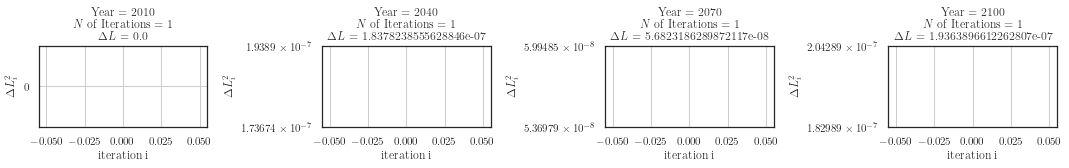

CPU times: user 24.9 s, sys: 1.1 s, total: 26 s
Wall time: 30.6 s


In [316]:
%%time
m5 = model(name='minor no South', sea_level=0, temperature=0.09)
m5.technology_calib()
m5.calib_migcosts()
m5.fertility()
m5.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Maximalist no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


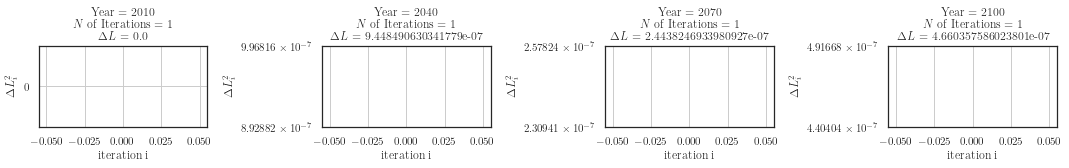

CPU times: user 26.5 s, sys: 1.2 s, total: 27.7 s
Wall time: 32.1 s


In [317]:
%%time
m6 = model(name='maximalist no South', sea_level=1.3, temperature=4.09)
m6.technology_calib()
m6.calib_migcosts()
m6.fertility()
m6.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Intermediate no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


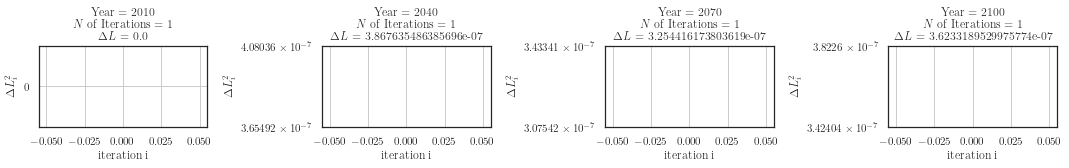

CPU times: user 25 s, sys: 1.27 s, total: 26.2 s
Wall time: 31 s


In [318]:
%%time
m7 = model(name='intermediate no North')
m7.technology_calib()
m7.calib_migcosts()
m7.fertility()
m7.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Minimalist no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


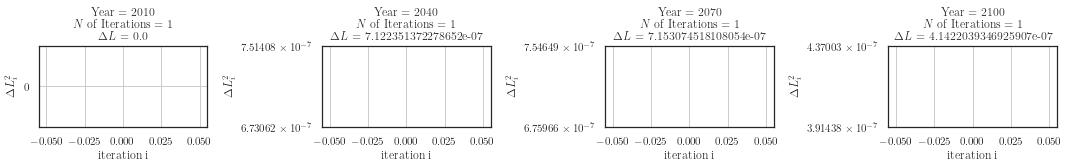

CPU times: user 25 s, sys: 1.28 s, total: 26.3 s
Wall time: 31.4 s


In [319]:
%%time
m8 = model(name='minimalist no North', sea_level=0, temperature=0.09)
m8.technology_calib()
m8.calib_migcosts()
m8.fertility()
m8.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Maximalist no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


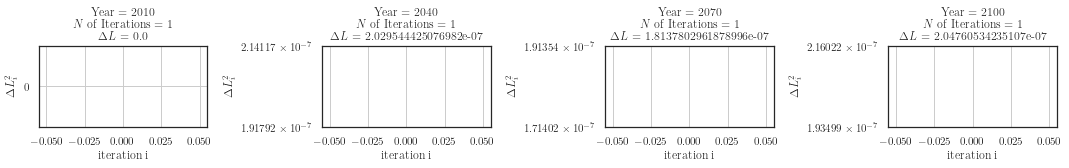

CPU times: user 24.8 s, sys: 1.39 s, total: 26.2 s
Wall time: 32 s


In [320]:
%%time
m9 = model(name='maximalist no North', sea_level=1.3, temperature=4.09)
m9.technology_calib()
m9.calib_migcosts()
m9.fertility()
m9.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Intermediate compensation for flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


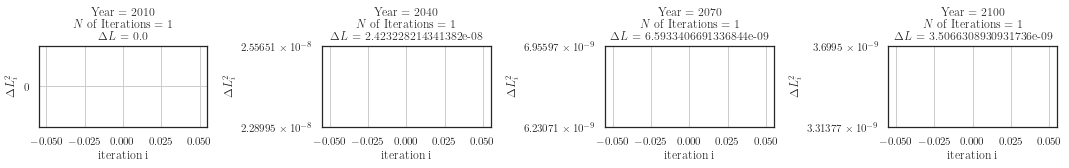

CPU times: user 24.5 s, sys: 1.75 s, total: 26.2 s
Wall time: 32.9 s


In [321]:
%%time
m10 = model(name="intermediate compensate flooded", χ={'d': 0.0, 'f': 0.0})
m10.technology_calib()
m10.calib_migcosts()
m10.fertility()
m10.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


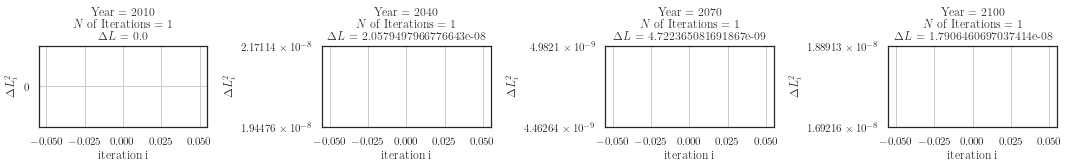

CPU times: user 26.2 s, sys: 1.42 s, total: 27.6 s
Wall time: 33.1 s


In [322]:
%%time
m10min = model(name="m compensate flooded", χ={'d': 0.0, 'f': 0.0},sea_level=0,temperature=0.09)
m10min.technology_calib()
m10min.calib_migcosts()
m10min.fertility()
m10min.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Intermediate proportional increase

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


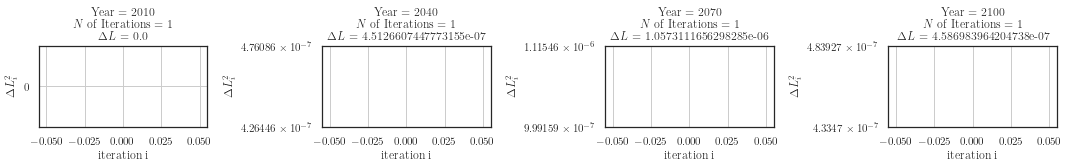

CPU times: user 25.2 s, sys: 1.62 s, total: 26.9 s
Wall time: 33.5 s


In [323]:
%%time
m11 = model(name="intermediate proportional increase")
m11.technology_calib()
m11.calib_migcosts()
m11.fertility()
m11.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proporional_increase')

## Intermediate proportional decrease

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


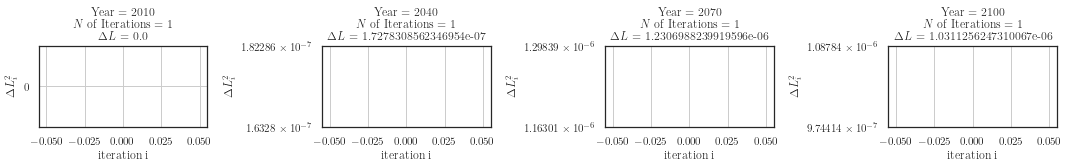

CPU times: user 25.2 s, sys: 2.16 s, total: 27.4 s
Wall time: 35.5 s


In [324]:
%%time
m12 = model(name="intermediate proportional decrease")
m12.technology_calib()
m12.calib_migcosts()
m12.fertility()
m12.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proporional_decrease')

## Intermediate no international

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


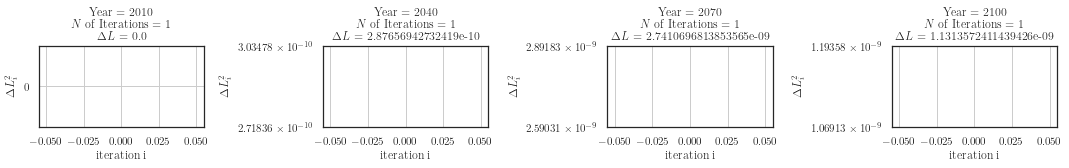

CPU times: user 24.7 s, sys: 1.55 s, total: 26.2 s
Wall time: 34.2 s


In [325]:
%%time
m13 = model(name="moderate no international mig",label='Moderate $x_{ij} = 1$')
m13.technology_calib()
m13.calib_migcosts()
m13.fertility()
m13.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_international')

## Intermediate no internal

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


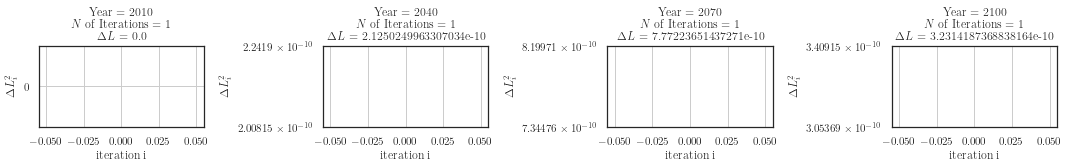

CPU times: user 24.4 s, sys: 1.54 s, total: 26 s
Wall time: 31.7 s


In [326]:
%%time
m14 = model(name="moderate no internal mig",label='Moderate $x_{ii} = 1$')
m14.technology_calib()
m14.calib_migcosts()
m14.fertility()
m14.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_internal')

## Intermediate no migration

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


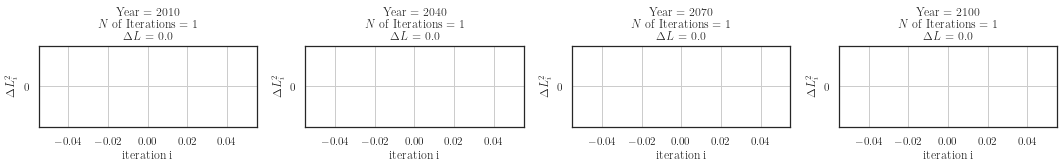

CPU times: user 24.1 s, sys: 1.51 s, total: 25.6 s
Wall time: 26.3 s


In [327]:
%%time
m15 = model(name="intermediate no mig")
m15.technology_calib()
m15.calib_migcosts()
m15.fertility()
m15.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no')

## Intermediate no flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


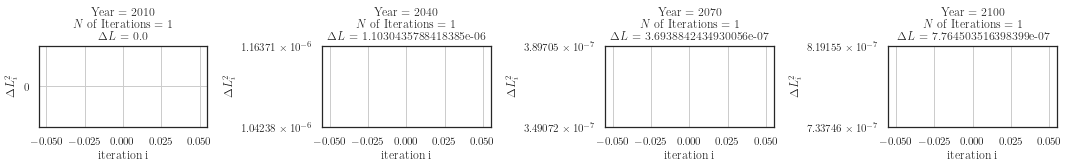

CPU times: user 23.8 s, sys: 1.28 s, total: 25 s
Wall time: 32.4 s


In [328]:
%%time
m16 = model(name="intermediate_no_sea_rise", sea_level=0)
m16.technology_calib()
m16.calib_migcosts()
m16.fertility()
m16.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Minimalist no flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


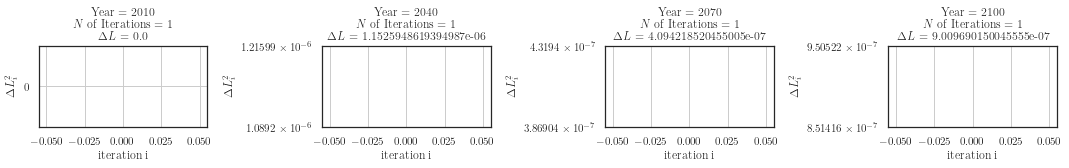

CPU times: user 24.8 s, sys: 1.67 s, total: 26.5 s
Wall time: 29.3 s


In [329]:
%%time
m17 = model(name="minimalist_no_sea_rise", sea_level=0, temperature=0.09)
m17.technology_calib()
m17.calib_migcosts()
m17.fertility()
m17.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Maximalist no flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


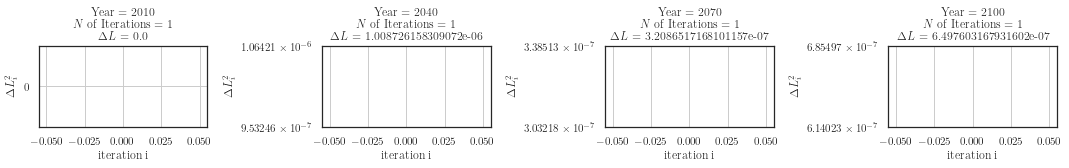

CPU times: user 23.7 s, sys: 2.08 s, total: 25.8 s
Wall time: 32.8 s


In [330]:
%%time
m18 = model(name="maximalist_no_sea_rise", sea_level=0, temperature=4.09)
#m18.ω = 0 * m18.ω # No sea-level rise
m18.technology_calib()
m18.calib_migcosts()
m18.fertility()
m18.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Intermediate no TFP effect

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


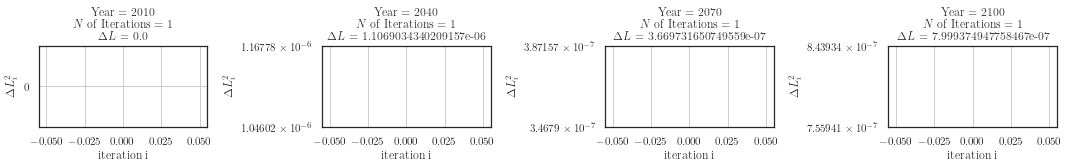

CPU times: user 24 s, sys: 1.55 s, total: 25.5 s
Wall time: 30.8 s


In [331]:
%%time
m19 = model(name="intermediate no TFP effect", temperature=0.09)
m19.technology_calib()
m19.calib_migcosts()
m19.fertility()
m19.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Maximalist, pessimistic sea level

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


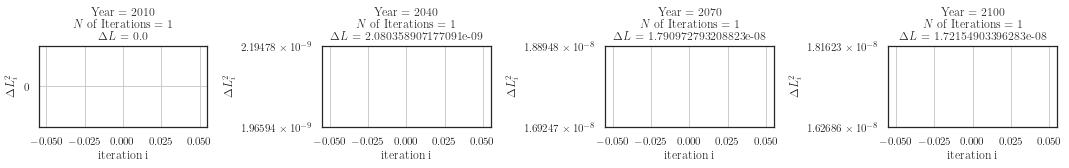

CPU times: user 23.6 s, sys: 1.44 s, total: 25.1 s
Wall time: 30.5 s


In [332]:
%%time
m20 = model(name='maximalist pessimistic sea level, bilateral mig', sea_level=2.7, temperature=4.09)
m20.technology_calib()
m20.calib_migcosts()
m20.fertility()
m20.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

In [333]:
for m in [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m10min,m11,m12,m13,m14,m15,m16,m17,m18,m19,m20]:
    m.save_output()

# Outputs

## Stackplots

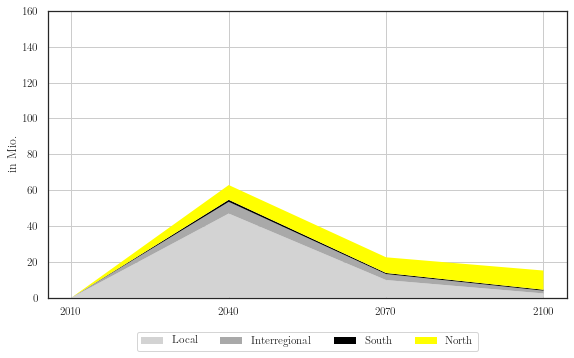

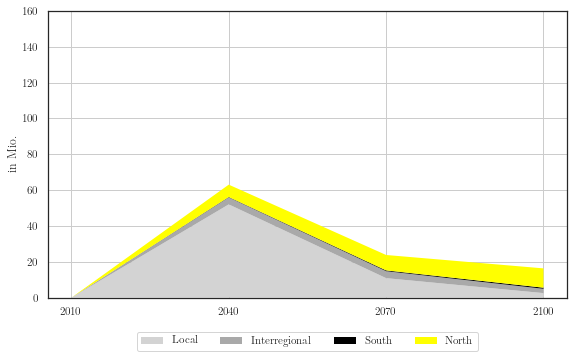

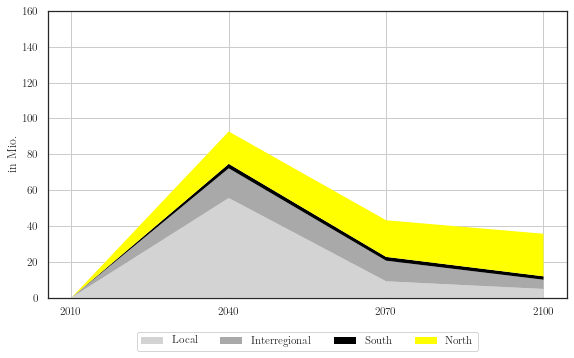

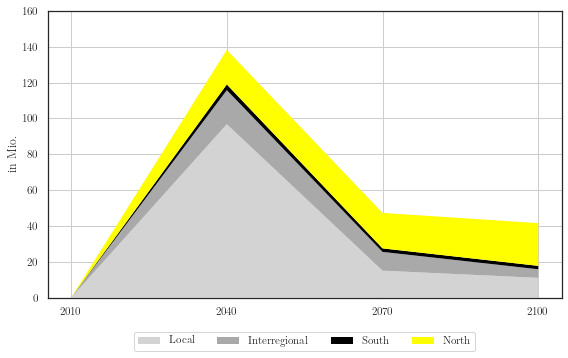

In [226]:
m1.out_stackplot(m2,save=True,name='int_min_full.pdf',ylim=160,title=None)
m10.out_stackplot(m10min,save=True,name='int_compenstation_full.pdf',ylim=160,title=None)
m3.out_stackplot(m2,save=True,name='max_min_full.pdf',ylim=160,title=None)
m20.out_stackplot(m2,save=True,name='max_pess_min_full.pdf',ylim=160,title=None)

In [339]:
only_Total_Total = False

migrants_minor = m2.out_migrant_world_stock()
climate_migrants_moderate = (m1.out_migrant_world_stock()-m2.out_migrant_world_stock())
climate_migrants_major = (m3.out_migrant_world_stock()-m2.out_migrant_world_stock())
climate_migrants_slr = (m20.out_migrant_world_stock()-m2.out_migrant_world_stock())


scenarios = [migrants_minor,
climate_migrants_moderate,
climate_migrants_major,
climate_migrants_slr]

migrants_minor.loc['Total'] = np.nan

for i in scenarios[1:]:
    i.loc['Total'] = i.sum(0)
    if only_Total_Total == True:
        i['Total'] = np.nan
        i['Total'].loc['Total'] = i.loc['Total'].sum()
    else:
        i['Total'] = i.sum(1)
    

In [349]:
tab = round(pd.concat(scenarios, keys=['Minor','$\Delta$ Moderate','$\Delta$ Major','$\Delta$ SLR+']),2)
tab = tab.unstack(1).stack('t').replace(np.nan, '$-$')

labels = ['Local','Interregional','North-North','North-South','South-North','South-South','Total']
newlabels = ['Local','Int-reg','N-N','N-S','S-N','S-S','Total']

tab.columns = pd.Series(tab.columns).replace(labels,newlabels)

tab = tab[newlabels]

tab = tab.drop(2010,axis=0,level='t')
display(tab)
write(tab.to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'),'climate_migration_worldwide')

Local  Int-reg    N-N   N-S     S-N     S-S   Total
                  t                                                          
Minor             2040     0.00   469.97  47.73  3.23  125.17  114.32     $-$
                  2070     0.00   441.81  31.63  2.15  142.13  133.64     $-$
                  2100     0.00   437.12  20.21  1.42  149.42  146.80     $-$
$\Delta$ Moderate 2040    46.94     6.53  -0.23 -0.21    8.47    1.34   62.84
                  2070     9.84     3.35  -0.03 -0.14    8.79    0.72   22.53
                  2100     2.38     1.52   0.20 -0.08   10.51    0.61   15.15
                  Total   59.16    11.41  -0.06 -0.44   27.77    2.68  100.52
$\Delta$ Major    2040    55.60    16.58  -0.41 -0.42   18.48    2.90   92.73
                  2070     9.14    11.50   0.10 -0.27   20.33    2.39    43.2
                  2100     4.87     5.16   0.43 -0.16   23.32    2.06   35.68
                  Total   69.61    33.25   0.12 -0.86   62.13    7.36  171.61
$\Delta$ SLR+     2040    96.79    19.00  -0.14 -0.40   19.40    3.58  138.24
                  2070    15.08    10.48  -0.00 -0.28   19.80    2.24   47.31
                  2100    11.07     4.79   0.41 -0.16   23.41    2.07   41.59
                  Total  122.94    34.27   0.27 -0.85   62.61    7.89  227.14

## Distribution plots

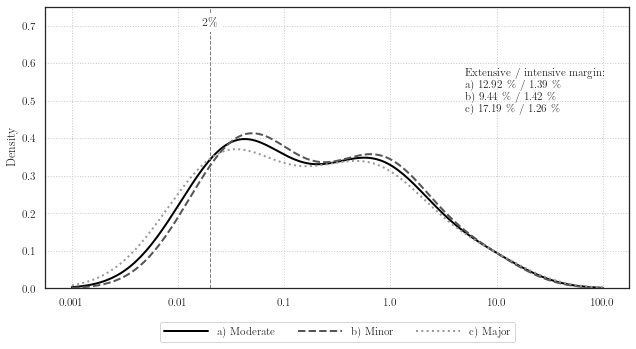

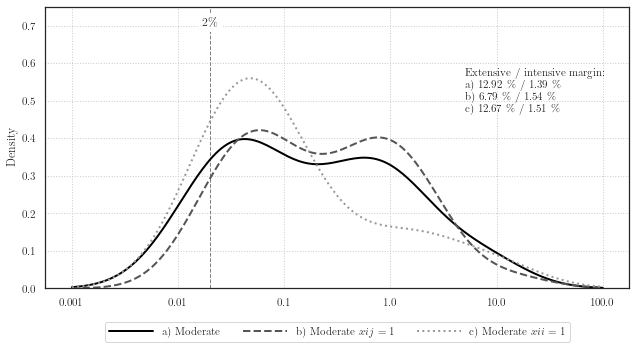

In [301]:
m1.out_distplot([m2,m3],text=True,save=True,cols=3,save_name='Fig7.pdf',show_scenario=False)
m1.out_distplot([m13,m14],text=True,save=True,save_name='closing_borders.pdf',cols=3,show_scenario=False)

# m1.out_distplot([m0],text=True,save=True,save_name='BDSvsBDDM.pdf',cols=1)
# m5.out_distplot([m4,m6],text=True,save=True,save_name='nosouth.pdf',cols=2)
# m8.out_distplot([m7,m9],text=True,save=True,save_name='nonorth.pdf',cols=2)
# m1.out_distplot([m4,m7],text=True,save=True,save_name='full_nosouth_nonorth.pdf',cols=2,show_scenario=False)
# m1.out_distplot([m11,m12],text=True,cols=2,save=True,save_name='proportional_change.pdf',show_scenario=False)
# m1.out_distplot([m10],text=True,cols=1,save=True,save_name='compensating_flooded.pdf',show_scenario=False)
# m1.out_distplot([m16],text=True,cols=1,save=True,save_name='no_flooding.pdf')
# m1.out_distplot([m19],text=True,cols=1,save=True,save_name='no_TFP_effect.pdf')
# m1.out_distplot([m20,m3],text=True,cols=1,save=True,save_name='pessimistic_sea_level.pdf')

## World aggregates table

In [302]:
def agg_ef_table(m,on='bddm'):
    tbl = out_world_aggregates(m,on).unstack(-2)[[2040,2070,2100]].swaplevel(1,0,1).stack().unstack().sort_index(0)
    return(tbl)

a = agg_ef_table(m2)
b = agg_ef_table(m1)-agg_ef_table(m2)
c = agg_ef_table(m3)-agg_ef_table(m2)
keys = ['Minor','$\Delta$ Moderate','$\Delta$ Major']
tab = pd.concat([a,b,c],keys=keys,axis=0).swaplevel(0,1,0)
tab = tab.sort_index(axis=0,level=[0,1],ascending=[True,False])

int_min = (m1.out_world_aggregates()-m2.out_world_aggregates()).drop(2010,1).T.reset_index()
max_min = (m3.out_world_aggregates()-m2.out_world_aggregates()).drop(2010,1).T.reset_index()
minimal = (m2.out_world_aggregates()).drop(2010,1).T.reset_index()
int_min['bddm'] = 'World'
int_min[''] = '$\Delta$ Moderate'
int_min = int_min.set_index(['bddm','t','']).unstack(1)
max_min['bddm'] = 'World'
max_min[''] = '$\Delta$ Major'
max_min = max_min.set_index(['bddm','t','']).unstack(1)
minimal['bddm'] = 'World'
minimal[''] = 'Minor'
minimal = minimal.set_index(['bddm','t','']).unstack(1)

tab = tab.append(pd.concat([minimal,max_min,int_min],0))

tab.sort_index(1) 

GDP in 10e9 \$US                     GDP per Worker  \
t                                   2040      2070      2100           2040   
bddm                                                                          
CARE  Minor                       783.29    869.58    891.40        7183.18   
      $\Delta$ Moderate           -21.55    -44.69    -59.63        -184.50   
      $\Delta$ Major              -49.83    -92.03   -121.58        -427.64   
EAP   Minor                      1935.86   2125.81   2082.82       19948.89   
      $\Delta$ Moderate          -100.09   -122.42   -121.31        -962.77   
      $\Delta$ Major             -196.35   -227.50   -230.42       -1888.32   
LAC   Minor                      1050.70   1128.45   1086.51       43688.49   
      $\Delta$ Moderate           -83.32   -102.32   -102.85       -3180.89   
      $\Delta$ Major             -185.01   -218.90   -220.11       -7098.39   
MENA  Minor                       858.78   1061.50   1134.43       30298.29   
      $\Delta$ Moderate           -29.37    -58.21    -56.87       -1078.14   
      $\Delta$ Major              -71.04   -118.40   -123.48       -2627.67   
OECD  Minor                      9920.86   9709.40   9324.28      173201.24   
      $\Delta$ Moderate           581.77    493.06    612.98        7423.08   
      $\Delta$ Major             1113.64   1042.39   1235.21       13294.16   
SSA   Minor                       430.52    815.15   1348.80        7396.72   
      $\Delta$ Moderate           -38.19    -86.34   -160.02        -634.79   
      $\Delta$ Major              -81.43   -176.73   -326.25       -1355.04   
World Minor                     14980.00  15709.89  15868.24       40057.35   
      $\Delta$ Major              529.99    208.83    213.38        1417.42   
      $\Delta$ Moderate           309.25     79.08    112.30         827.05   

                                              HS Share in \%                \
t                             2070       2100           2040   2070   2100   
bddm                                                                         
CARE  Minor                8021.62    9539.89          17.83  20.88  25.08   
      $\Delta$ Moderate    -379.98    -569.38          -0.08  -0.11  -0.05   
      $\Delta$ Major       -774.02   -1144.37          -0.17  -0.17  -0.04   
EAP   Minor               25916.63   32740.94          15.97  21.40  27.20   
      $\Delta$ Moderate   -1277.10   -1436.61          -0.14  -0.28  -0.08   
      $\Delta$ Major      -2327.46   -2628.43          -0.29  -0.39  -0.06   
LAC   Minor               52741.54   63687.59          32.34  37.95  43.68   
      $\Delta$ Moderate   -4173.56   -5010.56          -0.04  -0.08   0.09   
      $\Delta$ Major      -8922.53  -10691.00          -0.09   0.03   0.38   
MENA  Minor               34045.24   39862.56          29.03  31.66  35.42   
      $\Delta$ Moderate   -1818.87   -1951.17          -0.06  -0.54  -0.21   
      $\Delta$ Major      -3820.40   -4371.96          -0.14  -0.75  -0.37   
OECD  Minor              205933.60  242244.53          56.15  60.96  65.05   
      $\Delta$ Moderate    6208.47    8584.66          -0.05  -0.54  -0.37   
      $\Delta$ Major      12177.61   15713.00          -0.16  -0.81  -0.71   
SSA   Minor                7867.13    8029.50           5.05   5.52   5.55   
      $\Delta$ Moderate    -765.77    -828.54          -0.10  -0.11  -0.08   
      $\Delta$ Major      -1551.31   -1652.91          -0.22  -0.19  -0.13   
World Minor               39896.35   38793.41          23.01  23.53  22.65   
      $\Delta$ Major        910.94    1477.23           0.00  -0.02   0.35   
      $\Delta$ Moderate     357.33     638.17           0.00  -0.10   0.10   

                        Population in 10e6                 Urban Share in \%  \
t                                     2040    2070    2100              2040   
bddm                                                                           
CARE  Minor   

In [303]:
write(tab.to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c').replace('bddm',''),'world_aggregates')

## Tables on Emigration/Immigration Stocks

### Emigration

In [261]:
Mmin = m2.M.xs('International',0,'Type').groupby(['t','Country']).sum().unstack(['t'])[0]
Mint = m1.M.xs('International',0,'Type').groupby(['t','Country']).sum().unstack(['t'])[0]
Mmax = m3.M.xs('International',0,'Type').groupby(['t','Country']).sum().unstack(['t'])[0]

Nmin = m2.N.unstack().groupby(['Country','t']).sum().unstack(['t'])
Nint = m1.N.unstack().groupby(['Country','t']).sum().unstack(['t'])
Nmax = m3.N.unstack().groupby(['Country','t']).sum().unstack(['t'])

ESmin = (Mmin/Nmin).dropna(1)
ESint = (Mint/Nint).dropna(1)
ESmax = (Mmax/Nmax).dropna(1)

EStab = pd.concat([ESmin,(ESint-ESmin)[2100],(ESmax-ESmin)[2100]],
          keys=['Min','$\Delta$ Mod','$\Delta$ Maj'],axis=1)*100
EStab = round(EStab,2).sort_values(by=('$\\Delta$ Mod',2100),ascending=False).reset_index()
ESfinal = EStab.replace(m1.iso.index,m1.iso).head(34)

### Immigration

In [262]:
Imin = m2.M.xs('International',0,'Type').groupby(['t','Destination']).sum().unstack(['t'])[0]
Iint = m1.M.xs('International',0,'Type').groupby(['t','Destination']).sum().unstack(['t'])[0]
Imax = m3.M.xs('International',0,'Type').groupby(['t','Destination']).sum().unstack(['t'])[0]

Lmin = m2.L.unstack().groupby(['Country','t']).sum().unstack(['t'])
Lint = m1.L.unstack().groupby(['Country','t']).sum().unstack(['t'])
Lmax = m3.L.unstack().groupby(['Country','t']).sum().unstack(['t'])

ISmin = (Imin/Lmin).dropna(1)
ISint = (Iint/Lint).dropna(1)
ISmax = (Imax/Lmax).dropna(1)

IStab = pd.concat([ISmin,(ISint-ISmin)[2100],(ISmax-ISmin)[2100]],
          keys=['Min','$\Delta$ Mod','$\Delta$ Maj'],axis=1)*100

DESTINATIONS = list(m1.OECD[m1.OECD == 1].index)


IStab = round(IStab.loc[DESTINATIONS],2).sort_values(by=('$\\Delta$ Mod',2100),ascending=False)

ISfinal = IStab.reset_index().replace(m1.iso.index,m1.iso)

In [263]:
final = pd.concat([ESfinal,ISfinal],axis=1,keys=['Average Emigration Rate [\% of Natives]','Average Proportion of Foreigners [\% of Residents]'])
display(final)


Average Emigration Rate [\% of Natives]                              \
                                   Country    Min                        
t                                            2010   2040   2070   2100   
0                                      FSM  35.93  35.44  35.55  36.35   
1                                      GUY  55.58  64.24  64.86  68.42   
2                                      JAM  44.68  54.73  56.91  58.82   
3                                      TTO  33.12  36.30  38.01  40.24   
4                                      FJI  31.29  43.83  46.38  48.58   
5                                      SUR  49.15  58.50  58.53  57.45   
6                                      STP  36.68  48.02  52.83  56.42   
7                                      BLZ  29.53  40.47  42.38  44.56   
8                                      SLV  34.69  46.46  48.84  50.55   
9                                      GRD  56.09  54.73  58.27  61.43   
10                                     TON  56.77  58.80  56.98  57.00   
11                                     COM  17.07  17.44  17.40  17.87   
12                                     LCA  34.24  30.62  29.41  29.95   
13                                     NIC  17.15  21.21  22.20  22.91   
14                                     BRB  39.25  46.31  47.01  48.98   
15                                     VCT  49.06  53.49  55.78  57.69   
16                                     GNB  13.18  16.30  18.87  21.28   
17                                     GMB  11.20  15.03  18.49  22.37   
18                                     PHL  10.86  17.95  20.77  23.20   
19                                     LBR  16.14  19.14  20.20  21.28   
20                                     DOM  19.90  28.95  30.61  32.11   
21                                     HND  16.56  24.00  26.39  28.61   
22                                     MUS  17.78  26.80  28.27  30.00   
23                                     HTI  19.40  34.57  39.58  43.17   
24                                     LKA  12.47  10.45  10.70  11.36   
25                                     KGZ  23.50  22.96  22.80  23.71   
26                                     CUB  17.42  25.36  26.12  26.73   
27                                     WSM  30.65  42.97  42.63  43.36   
28                                     COG   9.75  14.38  16.04  16.85   
29                                     SEN  10.60  11.86  11.96  12.11   
30                                     GNQ  22.34  25.07  26.19  26.91   
31                                     KAZ  32.72  35.24  34.37  34.74   
32                                     HKG  18.93  22.85  23.78  24.67   
33                                     TLS   9.60  11.68  12.82  14.07   

                              \
   $\Delta$ Mod $\Delta$ Maj   
t          2100         2100   
0          6.00        13.73   
1          5.23        10.84   
2          4.08         8.79   
3          4.00         9.48   
4          3.92         8.37   
5          3.80         7.36   
6          3.69         7.53   
7          3.66         8.67   
8          3.54         7.57   
9          3.54         7.94   
10         3.32         7.76   
11         3.31         7.92   
12         3.19         7.87   
13         3.08         7.01   
14         3.04         7.29   
15         2.76         6.30   
16         2.53         5.19   
17         2.51         5.45   
18         2.46         5.60   
19         2.37         5.63   
20         2.35         5.17   
21         2.30         5.52   
22         2.26         5.33   
23         2.08         5.02   
24         2.05         5.03   
25         2.03         3.83   
26         1.97         4.31   
27         1.89         3.43   
28         1.87         4.16   
29         1.82         4.25   
30         1.72         4.26   
31         1.71         3.23   
32         1.67         3.65   
33         1.64         3.99   

   Average Proportion of Foreigners [\% of Residents]                       \
 

In [264]:
latex_out = final.to_latex(header=True,index=False,bold_rows=True,multicolumn=True,multirow = True,escape=False,sparsify=True,multicolumn_format='c',)
for i in ['Destination','Country']:
    latex_out = latex_out.replace(i,'')
latex_out = latex_out.replace('Average Emigration Rate [\% of Natives]','\multicolumn{7}{c}{Average Emigration Rate [\% of Natives]}')
latex_out = latex_out.replace('\multicolumn{2}{c}{2100}','2100 &')
write(latex_out,'migration_stocks')

## TFP convergence vs. divergence

Country
Afghanistan    15.931175
Albania        14.076899
Algeria        16.587011
Angola         15.640475
Argentina      16.739291
                 ...    
Venezuela      16.443559
Vietnam        17.553502
Yemen          15.794272
Zambia         15.206226
Zimbabwe       15.339106
Length: 179, dtype: float64

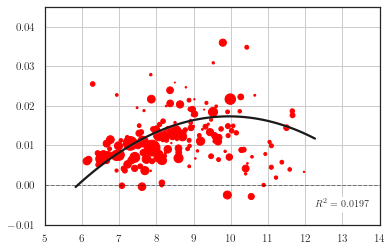

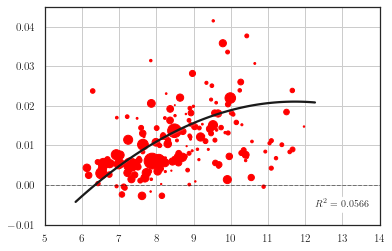

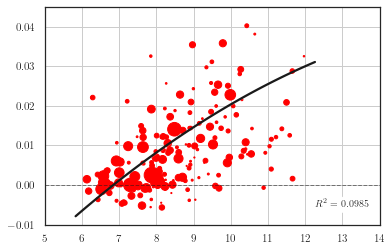

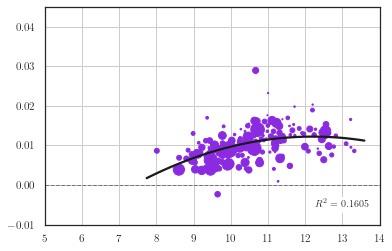

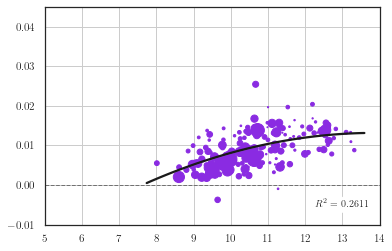

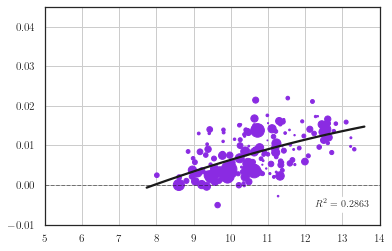

In [369]:
def TFP_plots():
    from matplotlib import rcParams
    from matplotlib import rc
    rcParams['font.family'] = 'serif'
    rc('text', usetex=True)
    for r in ['a','n']:
        for m in [m2,m1,m3]:
            if r == 'a':
                color = 'red'
            else:
                color= 'blueviolet'
            from scipy import stats
            def r2(x, y):
                return stats.pearsonr(x, y)[0] ** 2
            x = np.log(m.A[(r,2010)])
            y = 1/90*(m.A[(r,2100)]-m.A[(r,2010)])/m.A[(r,2010)]
            from scipy import stats
            def r2(x, y):
                return round(stats.pearsonr(x, y)[0] ** 2,4)
            fig = plt.figure()
            plt.axhline(0,color='k',lw=1,linestyle='dashed',alpha=0.5)
            ax = sns.regplot(x, y,order=2,marker='o',ci=0,color=color,scatter_kws={'alpha':1,'s':0.01*np.sqrt(m.L.xs(t,1,'t').sum(1))})
            plt.annotate('$R^2 =$ '+ str(r2(x,y)),(13,-0.005),bbox=dict(boxstyle="round", fc="w"),va='center',ha='center')
            regline = ax.get_lines()[1]
            regline.set_color('k')
            plt.xlabel('')
            plt.xlim([5,14])
            plt.ylim([-0.01,0.045])
            plt.grid()
            plt.show()
            fig.savefig('graphs/TFP/'+m.label+'_'+r+'.pdf')
TFP_plots()

## Skill of climate migrants

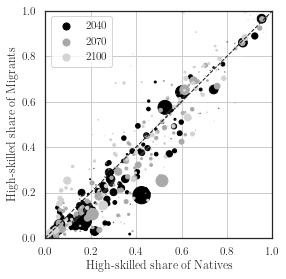

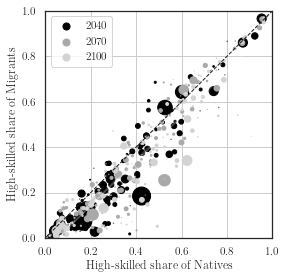

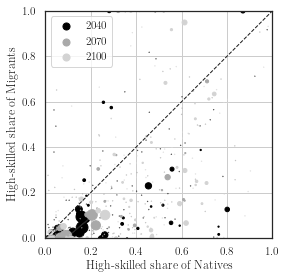

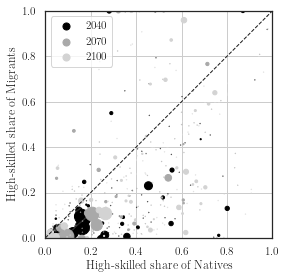

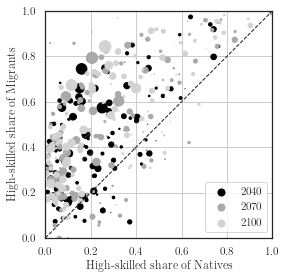

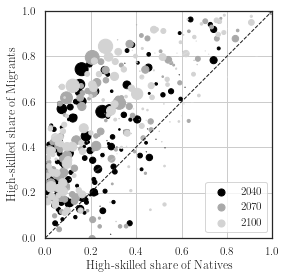

In [330]:
def skill_plots():
    from matplotlib import rcParams
    from matplotlib import rc
    rcParams['font.family'] = 'serif'
    rc('text', usetex=True)
    OECD = m1.OECD[m1.OECD == 1].index.to_list()
    for Type in ['Local','Internal','International']:
        for m in [m1,m3]:
            N = m.N.unstack().groupby(['Country','t']).sum().unstack('t')
            N_h = m.N.xs('h',1,'s').unstack().groupby(['Country','t']).sum().unstack('t')
            N_HS = N_h/N

            M = (m.M-m2.M)[0].groupby(['Country','t','Type']).sum().unstack(['Type','t'])
            M_h = (m.M-m2.M)[0].xs('h',0,'s').groupby(['Country','t','Type']).sum().unstack(['Type','t'])
            M_HS = M_h/M

            if Type == 'International':
                M = (m.M-m2.M)[0].xs('S-N',0,'F-T').groupby(['Country','t','Type']).sum().unstack(['Type','t'])
                M_h = (m.M-m2.M)[0].xs('S-N',0,'F-T').xs('h',0,'s').groupby(['Country','t','Type']).sum().unstack(['Type','t'])
                M_HS = (M_h/M)        
                N_HS = N_HS.drop(OECD,0)


            fig = plt.figure(figsize=(4,4))
            for t in [2040,2070,2100]:
                x = N_HS[t]
                y = M_HS[Type][t]
                sns.regplot(x,y,marker='o',color={2040:'black',2070:'darkgrey',2100:'lightgrey'}[t],label=t,order=1,ci=0,scatter_kws={'s':0.1*np.sqrt(np.maximum(M,1))[Type][t],'alpha':1},line_kws={'alpha':0})
            ax = plt.gca()
            ymin, ymax = ax.get_ylim()
            line45 = np.linspace(0,1)
            ax.plot(line45, line45,color='k',lw=1,linestyle='dashed')
            ax.set_aspect(1.0)
            plt.xlabel('High-skilled share of Natives')
            plt.ylabel('High-skilled share of Migrants')
            plt.xlim([0,1])
            plt.ylim([0,1])
            lgnd = plt.legend()
            for bullet in [0,1,2]:
                lgnd.__dict__['legendHandles'][bullet].__dict__['_sizes'] = np.array([50])
            plt.tight_layout()
            plt.grid()
            plt.show()
            fig.savefig('graphs/skill_composition/{label}_{Type}.pdf'.format(label=m.label,Type=Type))
skill_plots()

## Migration summary table

In [35]:
writer = pd.ExcelWriter('Migration.xlsx', engine='xlsxwriter')

for m in [m2,m1,m3]:
    Natives = pd.concat([m.N.stack(['r','s'])],1,keys=['Natives'],names=['Type'])

    InternalLocal = m.M.unstack('Type').groupby(['Country','r','s','t']).sum().unstack('t')[0].drop('International',1).drop('Stayers',1)
    #InternalLocal.index = InternalLocal.index.set_names('Country', level=0)

    International = m.M.xs('International',0,'Type').groupby(['Country','r','s','t','F-T']).sum().unstack(['F-T','t'])[0]
    #International.columns = International.columns.set_names('Type',level='F-T')

    tab = Natives.join([InternalLocal,International]).swaplevel(1,0,1).sort_index(1)

    tab = tab.reindex(['Natives', 'Local', 'Internal', 'N-N', 'N-S', 'S-N', 'S-S'], axis=1, level='Type')
    tab.to_excel(writer, sheet_name=m.label)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [88]:
tab

t                        2010                                              \
Type                  Natives Local       Internal N-N N-S            S-N   
Country     r s                                                             
Afghanistan a h  3.326619e+05   0.0       0.000000 NaN NaN   34943.697592   
              l  8.106200e+06   0.0       0.000000 NaN NaN  130324.619976   
            n h  2.958607e+05   0.0   57605.351379 NaN NaN   38906.606651   
              l  2.415715e+06   0.0  839356.412150 NaN NaN  152886.841905   
Albania     a h  5.621084e+04   0.0       0.000000 NaN NaN   46639.327856   
...                       ...   ...            ...  ..  ..            ...   
Zambia      n l  1.354252e+06   0.0  215847.423596 NaN NaN   12123.011467   
Zimbabwe    a h  6.245375e+04   0.0       0.000000 NaN NaN   30760.778152   
              l  3.890570e+06   0.0       0.000000 NaN NaN   44852.026710   
            n h  9.824825e+04   0.0    4114.459181 NaN NaN   58958.158710   
              l  9.566087e+05   0.0  749415.650217 NaN NaN   47082.459714   

t                                      2040                            ...  \
Type                      S-S       Natives       Local      Internal  ...   
Country     r s                                                        ...   
Afghanistan a h  4.809498e+04  1.067185e+06    0.000000  0.000000e+00  ...   
              l  1.136525e+06  1.501274e+07    0.000000  0.000000e+00  ...   
            n h  5.354935e+04  8.628201e+05    0.000000  1.628181e+05  ...   
              l  1.333284e+06  2.195642e+06    0.000000  1.563649e+06  ...   
Albania     a h  4.071564e+03  6.742633e+04  557.716536  0.000000e+00  ...   
...                       ...           ...         ...           ...  ...   
Zambia      n l  4.524574e+04  1.730333e+06    0.000000  6.150240e+05  ...   
Zimbabwe    a h  1.386365e+04  1.659920e+05    0.000000  0.000000e+00  ...   
              l  2.358055e+05  4.815420e+06    0.000000  0.000000e+00  ...   
            n h  2.657199e+04  5.351019e+05    0.000000  8.938199e+03  ...   
              l  2.475318e+05  2.932392e+06    0.000000  8.716130e+05  ...   

t                         2070                        2100            \
Type                       S-N           S-S       Natives     Local   
Country     r s                                                        
Afghanistan a h  164606.924543  1.817709e+05  1.827471e+06  0.000000   
              l  407204.872780  2.208105e+06  1.519093e+07  0.000000   
            n h  180806.384879  1.996595e+05  1.426305e+06  0.000000   
              l  221972.620971  1.203667e+06  2.134509e+06  0.000000   
Albania     a h   22595.505839  1.817640e+03  1.102363e+04  5.848563   
...                        ...           ...           ...       ...   
Zambia      n l   40954.208130  8.117890e+04  3.418690e+06  0.000000   
Zimbabwe    a h  111213.699529  3.855625e+04  2.482355e+05  0.000000   
              l  126426.430447  4.472052e+05  7.181348e+06  0.000000   
            n h  539198.138061  1.869325e+05  9.238190e+05  0.000000   
              l  316939.962473  1.121104e+06  3.506031e+06  0.000000   

t                                                                   \
Type                 Internal N-N N-S            S-N           S-S   
Country     r s                                                      
Afghanistan a h  0.000000e+00 NaN NaN  181377.564953  1.953297e+05   
              l  0.000000e+00 NaN NaN  354839.866608  1.894748e+06   
            n h  2.571590e+05 NaN NaN  216984.876695  2.336760e+05   
              l  1.602801e+06 NaN NaN  201296.209207  1.074867e+06   
Albania     a h  0.000000e+00 NaN NaN    8987.493882  7.227918e+02   
...                       ...  ..  ..            ...           ...   
Zambia      n l  3.722581e+06 NaN NaN   66861.271785  1.241768e+05   
Zimbabwe    a h  0.000000e+00 NaN NaN  137117.160059  4.608584e+04   
              l  0.000000e+00 NaN NaN  165533.307